In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.cm as cm
import pandas as pd
import os
from pathlib import Path
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders
from pyalex import config
from tqdm import tqdm 
import json
from collections import defaultdict
import itertools
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

In [2]:
pub_tracker = pd.read_csv("publication_tracker.csv")
pub_people = pd.read_csv("people_to_publication_mapping.csv")
combined_teams = pd.read_csv("final_team_roster.csv")

In [3]:
research_theme = pd.read_csv("CRN Team x Research Theme - Sheet1.csv")

## Cells to prep for all graphs

In [4]:
network_df = pub_tracker.merge(pub_people[['WorkOpenAlex_ID', 'PersonOpenAlex_ID', 'PersonName',
       'PersonOrcid', 'Role', 'Team', 'IsCorrespondingAuthor']],
       left_on='OpenAlex_ID',
       right_on='WorkOpenAlex_ID',
       how = 'left').drop(columns=['WorkOpenAlex_ID'])

In [5]:
# Define key roles
key_roles = ['Co-PI', 'Lead PI', 'Lead-PI']

# 1️⃣ Find all works that have at least one key role
works_with_key_roles = (
    network_df[network_df['Role'].isin(key_roles)]
    ['OpenAlex_ID']
    .unique()
)

# 2️⃣ Find works that do NOT have any key roles
works_without_key_roles = network_df.loc[
    ~network_df['OpenAlex_ID'].isin(works_with_key_roles),
    'OpenAlex_ID'
].unique()

# 3️⃣ From those works, collect people with non-null Role and Team
people_in_nonkey_works = (
    network_df[
        network_df['OpenAlex_ID'].isin(works_without_key_roles)
        & network_df['Role'].notna()
        & network_df['Team'].notna()
    ]['PersonOpenAlex_ID']
    .unique()
)

# 4️⃣ Finally, filter network_df
main_pi_df = network_df[
    network_df['Role'].isin(key_roles)
    | network_df['PersonOpenAlex_ID'].isin(people_in_nonkey_works)
].copy()


In [6]:
main_pi_df = main_pi_df[main_pi_df['Team'].notna()]


In [7]:
original_network_df = network_df[network_df["original"] == 1]

Check work count for all original research works

In [8]:
original_network_df["OpenAlex_ID"].nunique()

428

In [9]:
main_pi_df = main_pi_df[main_pi_df["Team"] != "MAC"]

In [10]:
main_pi_df = main_pi_df.merge(combined_teams[['Team','Supplement', 'Category',
       'Round']], on='Team', how='left' )

In [11]:
for col in main_pi_df.columns:
    if main_pi_df[col].apply(lambda x: isinstance(x, list)).any():
        main_pi_df[col] = main_pi_df[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)

main_pi_df = main_pi_df.drop_duplicates()


## Add Research Theme Column

In [12]:
main_pi_df = main_pi_df.merge(research_theme, left_on='Team', right_on='team', how='left' )

In [13]:
main_pi_df.columns

Index(['Title', 'team_x', 'doi_pre', 'doi_pub', 'date_added_preprint',
       'date_added_publication', 'source_preprint', 'source_publication',
       'original', 'notes', 'Preprint in SF tracker',
       'publication in SF tracker', 'apc_amount', 'apc_status', 'OpenAlex_ID',
       'PersonOpenAlex_ID', 'PersonName', 'PersonOrcid', 'Role', 'Team',
       'IsCorrespondingAuthor', 'Supplement', 'Category', 'Round', 'team_y',
       'research_theme'],
      dtype='object')

In [14]:
main_pi_df = main_pi_df.drop(columns=["team_y"])

## Filter to keep original research works only

In [15]:
# Step 1: Filter to only original == 1
filtered_df = main_pi_df[main_pi_df["original"] == 1].copy()

# Step 2: Identify the key combinations that should always be present
pi_roles = ['Co-PI', 'Lead PI', 'Lead-PI']
pi_rows = main_pi_df[main_pi_df["Role"].isin(pi_roles)][["Team", "PersonName"]].drop_duplicates()

# Step 3: Find which (Team, PersonName) pairs are missing after filtering
filtered_pairs = filtered_df[["Team", "PersonName"]].drop_duplicates()
missing_pairs = pd.merge(
    pi_rows,
    filtered_pairs,
    on=["Team", "PersonName"],
    how="left",
    indicator=True
).query('_merge == "left_only"')[["Team", "PersonName"]]

# Step 4: Pull those missing rows from the original df
cols_to_keep = [
    'PersonOpenAlex_ID', 'PersonName', 'Role', 'Team',
    'Supplement', 'Category', 'Round'
]
missing_rows = main_pi_df.merge(missing_pairs, on=["Team", "PersonName"], how="inner")[cols_to_keep].drop_duplicates()

# Step 5: Add them back into the filtered df
main_pi_df = pd.concat([filtered_df, missing_rows], ignore_index=True)


Check work count for PI original research works

In [16]:
main_pi_df["OpenAlex_ID"].nunique()

401

## Graph for number of publications by team and supplement

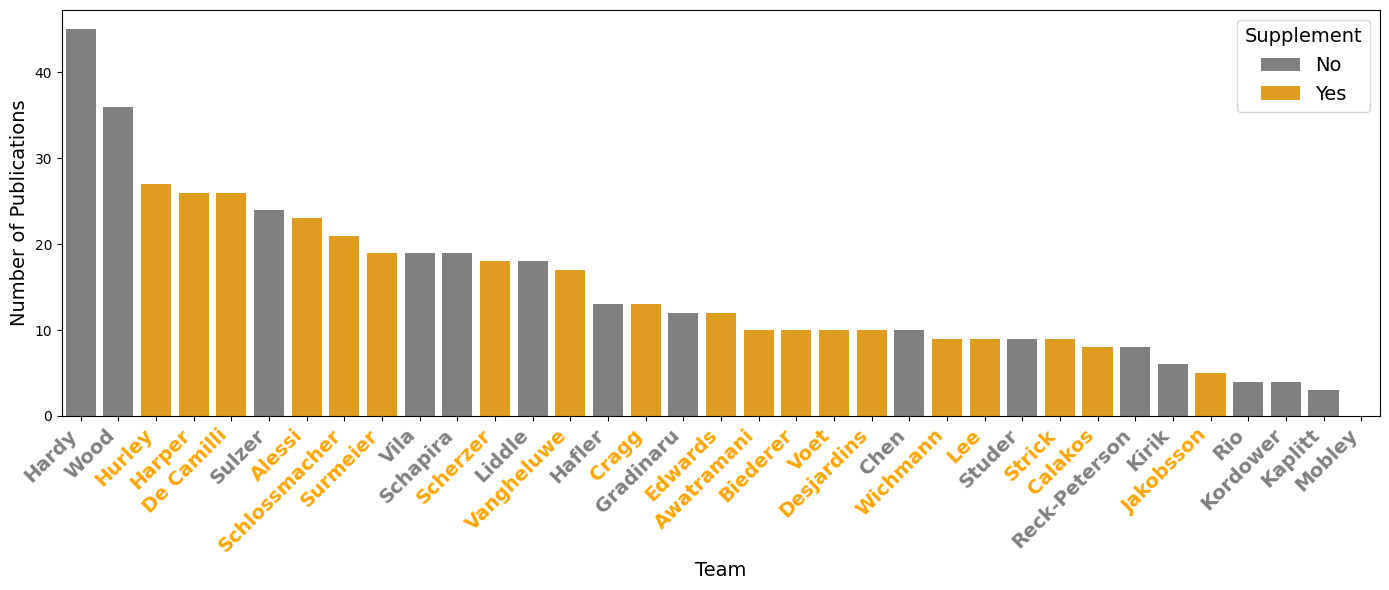

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: compute number of publications per team
team_pubs = (
    main_pi_df.groupby(["Team", "Supplement"])["OpenAlex_ID"]
    .nunique()  # count unique publications
    .reset_index(name="NumPubs")
)

# Step 2: define colors for Supplement
colors = {"Yes": "orange", "No": "grey"}

# Step 3: sort teams by total publications (optional)
team_pubs = team_pubs.sort_values("NumPubs", ascending=False)

# Step 4: plot
plt.figure(figsize=(14,6))
sns.barplot(
    data=team_pubs,
    x="Team",
    y="NumPubs",
    hue="Supplement",
    palette=colors
)

# Step 5: customize x-axis labels (color + bold)
ax = plt.gca()
for tick_label in ax.get_xticklabels():
    team_name = tick_label.get_text()
    # get supplement value for this team
    supp = team_pubs.loc[team_pubs["Team"]==team_name, "Supplement"].values[0]
    tick_label.set_color(colors[supp])
    tick_label.set_fontsize(14)
    tick_label.set_fontweight("bold")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Team", fontsize=14)
plt.ylabel("Number of Publications", fontsize=14)
#plt.title("Total Publications per Team by Supplement")
plt.legend(title="Supplement", title_fontsize=14, fontsize=14)
plt.tight_layout()
#plt.savefig('num_team_pubs_by_supplement.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [18]:
{"PD Functional Genomics": "green", "Circuitry and Brain-Body Interactions": "blue", "Neuro-Immune Interactions":"purple"}

{'PD Functional Genomics': 'green',
 'Circuitry and Brain-Body Interactions': 'blue',
 'Neuro-Immune Interactions': 'purple'}

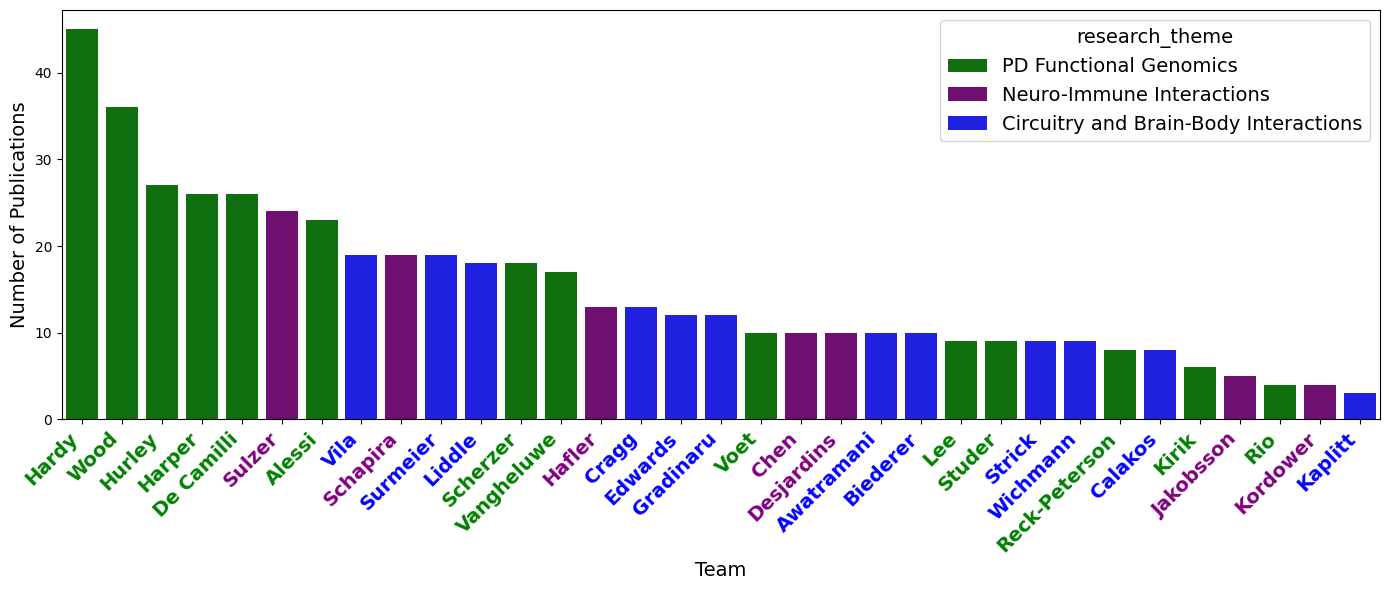

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: compute number of publications per team
team_pubs = (
    main_pi_df.groupby(["Team", "research_theme"])["OpenAlex_ID"]
    .nunique()  # count unique publications
    .reset_index(name="NumPubs")
)

# Step 2: define colors for research_theme
colors = {"PD Functional Genomics": "green", "Circuitry and Brain-Body Interactions": "blue", "Neuro-Immune Interactions":"purple"}

# Step 3: sort teams by total publications (optional)
team_pubs = team_pubs.sort_values("NumPubs", ascending=False)

# Step 4: plot
plt.figure(figsize=(14,6))
sns.barplot(
    data=team_pubs,
    x="Team",
    y="NumPubs",
    hue="research_theme",
    palette=colors
)

# Step 5: customize x-axis labels (color + bold)
ax = plt.gca()
for tick_label in ax.get_xticklabels():
    team_name = tick_label.get_text()
    # get research_theme value for this team
    supp = team_pubs.loc[team_pubs["Team"]==team_name, "research_theme"].values[0]
    tick_label.set_color(colors[supp])
    tick_label.set_fontsize(14)
    tick_label.set_fontweight("bold")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Team", fontsize=14)
plt.ylabel("Number of Publications", fontsize=14)
#plt.title("Total Publications per Team by research_theme")
plt.legend(title="research_theme", title_fontsize=14, fontsize=14)
plt.tight_layout()
plt.savefig('rt_num_team_pubs_by_research_theme.pdf', bbox_inches='tight', dpi=300)
plt.show()


### Main collab network prep

In [20]:
# Backend for network

# Fix: For each (PersonName, Team), assign the first encountered OpenAlex ID
def deduplicate_ids(df):
    id_map = (
        df.groupby(['PersonName', 'Team'])['PersonOpenAlex_ID']
        .first()
        .reset_index()
        .set_index(['PersonName', 'Team'])['PersonOpenAlex_ID']
        .to_dict()
    )
    df['PersonOpenAlex_ID'] = df.apply(
        lambda row: id_map[(row['PersonName'], row['Team'])],
        axis=1
    )
    return df

main_pi_df = deduplicate_ids(main_pi_df)


# Drop rows where PersonOpenAlex_ID is blank or null
filtered_df = main_pi_df[main_pi_df['PersonOpenAlex_ID'].notnull() & (main_pi_df['PersonOpenAlex_ID'] != '')]

# Identify the first consistent name per (PersonOpenAlex_ID, Team)
id_team_name_map = (
    filtered_df.groupby(['PersonOpenAlex_ID', 'Team'])['PersonName']
    .first()
    .to_dict()
)

# Apply the consistent name back to the original DataFrame
def standardize_name(row):
    key = (row['PersonOpenAlex_ID'], row['Team'])
    if pd.notna(row['PersonOpenAlex_ID']) and row['PersonOpenAlex_ID'] != '' and key in id_team_name_map:
        return id_team_name_map[key]
    return row['PersonName']

main_pi_df['PersonName'] = main_pi_df.apply(standardize_name, axis=1)



# Step 1: Normalize multi-team membership
multi_team_df = main_pi_df.dropna(subset=['Team']).drop_duplicates(subset=['PersonName', 'Team'])
person_teams = multi_team_df.groupby('PersonName')['Team'].apply(set).to_dict()

G = nx.Graph()

# --- Add team edges ---
teams = main_pi_df.groupby("Team")
for team_name, group in teams:
    members = group[['PersonName', 'PersonOpenAlex_ID']].drop_duplicates()
    member_names = members['PersonName'].tolist()
    for name1, name2 in itertools.combinations(member_names, 2):
        if name1 != name2:
            if G.has_edge(name1, name2):
                G[name1][name2]['weight'] += 10  # Increase weight
                if G[name1][name2]['type'] == 'collab':
                    G[name1][name2]['type'] = 'both'
            else:
                G.add_edge(name1, name2, weight=10, type='team')

# --- Add collaboration edges ---
# --- Add collaboration edges ---
collab_groups = main_pi_df.groupby("OpenAlex_ID")
collab_weights = defaultdict(int)

for _, group in collab_groups:
    unique_people = group[['PersonName']].drop_duplicates()['PersonName'].tolist()
    for name1, name2 in itertools.combinations(unique_people, 2):
        if name1 != name2:
            key = tuple(sorted((name1, name2)))
            collab_weights[key] += 1

# Now merge collab edges into the graph
for (name1, name2), collab_count in collab_weights.items():
    weight = 1 + collab_count * 2  # ← scale this multiplier as needed for visual clarity
    if G.has_edge(name1, name2):
        # Update weight based only on collaboration count
        G[name1][name2]['weight'] = weight
        G[name1][name2]['type'] = 'both' if G[name1][name2]['type'] == 'team' else 'collab'
    else:
        G.add_edge(name1, name2, weight=weight, type='collab')





# Step 5: Calculate layout (influenced by both edge types)
pos = nx.spring_layout(G, weight='weight', seed=42, k=0.4)

# Step 6: Color coding
unique_teams = sorted(set(itertools.chain.from_iterable(person_teams.values())))



import colorcet as cc
color_palette = cc.glasbey[:40]  # Very distinct and high-contrast


team_color_dict = {
    team: color_palette[i % len(color_palette)]
    for i, team in enumerate(unique_teams)
}


# Assign primary team color
node_colors = []
for node in G.nodes():
    teams = list(person_teams.get(node, []))
    color = team_color_dict.get(teams[0], "#cccccc") if teams else "#cccccc"
    node_colors.append(color)

# Step 7: Prepare edge styles


# Select only collab and both-type edges
collab_edges = [(u, v) for u, v, d in G.edges(data=True) if d['type'] in ('collab', 'both')]
collab_weights_list = [G[u][v]['weight'] *1.3 for u, v in collab_edges]

from collections import defaultdict

# Mapping from name to team
name_to_team = dict(zip(main_pi_df['PersonName'], main_pi_df['Team']))

# Initialize intra-team collaboration count
from collections import defaultdict

# Build person → set of teams map
person_team_map = defaultdict(set)
for _, row in main_pi_df.iterrows():
    if pd.notna(row['Team']):
        person_team_map[row['PersonName']].add(row['Team'])

# Internal and external collab counters
#internal_team_collabs = defaultdict(int)
#external_team_collabs = defaultdict(int)

# Go through collab edges
#for u, v, data in G.edges(data=True):
#    if data.get('type') in ('collab', 'both'):
#        shared_teams = person_team_map[u].intersection(person_team_map[v])
#        if shared_teams:
#            weight = data.get('weight', 1)
#            internal_team_collabs[u] += weight
#            internal_team_collabs[v] += weight
#        else:
#            weight = data.get('weight', 1)
#            external_team_collabs[u] += weight
#            external_team_collabs[v] += weight

# Example structure:
# name_to_teams = {'Alice': {'Team A', 'Team B'}, 'Bob': {'Team B'}, 'Charlie': {'Team C'}}



internal_team_collabs = defaultdict(int)
external_team_collabs = defaultdict(int)

for u, v, data in G.edges(data=True):
    if data['type'] not in ['collab', 'both']:
        continue
    
    teams_u = person_team_map.get(u, set())
    teams_v = person_team_map.get(v, set())

    shared_teams = teams_u & teams_v  # set intersection

    # Determine how many times they collaborated
    weight = data.get('weight', 1)

    if shared_teams:
        # Internal collab for both
        internal_team_collabs[u] += weight
        internal_team_collabs[v] += weight
    else:
        # External collab for both
        external_team_collabs[u] += weight
        external_team_collabs[v] += weight


# Assign primary team based on LEAST internal collaboration
primary_team_map = {}
for person, teams in person_team_map.items():
    collab_counts = {
        team: sum(
            G[u][v].get('weight', 1)
            for u, v in G.edges(person)
            if team in person_team_map.get(v, set())
        )
        for team in teams
    }
    if collab_counts:
        primary_team = min(collab_counts, key=collab_counts.get)
    else:
        primary_team = next(iter(teams))  # fallback
    primary_team_map[person] = primary_team




### Values for legend

In [21]:
# Normalize teams to lists, if not already
def to_team_list(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        return [t.strip() for t in x.split(";") if t.strip()]
    return []

main_pi_df["Team_List"] = main_pi_df["Team"].apply(to_team_list)

# Identify Mina Ryten’s works
mina_works = main_pi_df.loc[main_pi_df["PersonName"] == "Mina Ryten", "OpenAlex_ID"].unique()

# Define target teams
target_teams = {"Hardy", "Wood"}

# Initialize counter
works_with_hardy_or_wood = set()

for work, df_work in main_pi_df.groupby("OpenAlex_ID"):
    if work not in mina_works:
        continue  # skip works that don't include Mina Ryten

    # exclude Mina herself
    df_others = df_work[df_work["PersonName"] != "Mina Ryten"]

    # check if any other person's Team_List includes Hardy or Wood
    has_target_team = df_others["Team_List"].apply(lambda lst: any(t in target_teams for t in lst)).any()

    if has_target_team:
        works_with_hardy_or_wood.add(work)

count_works = len(works_with_hardy_or_wood)

print(f"Mina Ryten has {count_works} works with at least one person from teams Hardy or Wood.")


Mina Ryten has 19 works with at least one person from teams Hardy or Wood.


In [22]:
import pandas as pd
from collections import Counter, defaultdict
from itertools import combinations

# Assuming you have: main_pi_df with columns ["OpenAlex_ID", "PersonOpenAlex_ID", "Team"]
# and id_to_name mapping (OpenAlex_ID → full name)

# -------------------------------------------------------------
# 1️⃣ Most frequent collaborator pair
# -------------------------------------------------------------

id_to_name = network_df.drop_duplicates("PersonOpenAlex_ID").set_index("PersonOpenAlex_ID")["PersonName"].to_dict()

pair_counts = Counter()

for work, group in main_pi_df.groupby("OpenAlex_ID"):
    people = group["PersonOpenAlex_ID"].dropna().unique()
    for p1, p2 in combinations(sorted(people), 2):
        pair_counts[(p1, p2)] += 1

# Top pair
top_pair, top_pair_count = pair_counts.most_common(1)[0]
name1 = id_to_name.get(top_pair[0], top_pair[0])
name2 = id_to_name.get(top_pair[1], top_pair[1])

print(f"Most frequent collaborator pair:")
print(f"{name1} ({top_pair[0]}) & {name2} ({top_pair[1]}) -> {top_pair_count} shared works")

# -------------------------------------------------------------
# 2️⃣ Person with most works including same-team collaborators
# -------------------------------------------------------------

person_same_team_works = defaultdict(set)

for work, group in main_pi_df.groupby("OpenAlex_ID"):
    for team, sub in group.groupby("Team"):
        if len(sub) > 1:  # at least 2 people from the same team
            for person in sub["PersonOpenAlex_ID"]:
                person_same_team_works[person].add(work)

same_team_counts = pd.Series({p: len(w) for p, w in person_same_team_works.items()}).sort_values(ascending=False)
top_same_team_person = same_team_counts.index[0]
top_same_team_count = same_team_counts.iloc[0]
top_same_team_name = id_to_name.get(top_same_team_person, "Unknown")

print(f"\nPerson with most works including same-team collaborators (multi-team aware):")
print(f"{top_same_team_name} ({top_same_team_person}) -> {top_same_team_count} works")

# -------------------------------------------------------------
# 3️⃣ Person with most works including other-team collaborators
# -------------------------------------------------------------

person_other_team_works = defaultdict(set)

for work, group in main_pi_df.groupby("OpenAlex_ID"):
    teams = group["Team"].dropna().unique()
    if len(teams) > 1:  # work includes multiple teams
        for team, sub in group.groupby("Team"):
            if len(sub) > 0:  # everyone in every team on that work gets credit
                for person in sub["PersonOpenAlex_ID"]:
                    person_other_team_works[person].add(work)

other_team_counts = pd.Series({p: len(w) for p, w in person_other_team_works.items()}).sort_values(ascending=False)
top_other_team_person = other_team_counts.index[0]
top_other_team_count = other_team_counts.iloc[0]
top_other_team_name = id_to_name.get(top_other_team_person, "Unknown")

print(f"\nPerson with most works including other-team collaborators (multi-team aware):")
print(f"{top_other_team_name} ({top_other_team_person}) -> {top_other_team_count} works")


Most frequent collaborator pair:
John Hardy (A5020514779) & Huw Morris (A5082416184) -> 13 shared works

Person with most works including same-team collaborators (multi-team aware):
John Hardy (A5020514779) -> 19 works

Person with most works including other-team collaborators (multi-team aware):
Mina Ryten (A5042439287) -> 23 works


In [23]:
# Normalize teams to lists, if not already
def to_team_list(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        return [t.strip() for t in x.split(";") if t.strip()]
    return []

main_pi_df["Team_List"] = main_pi_df["Team"].apply(to_team_list)

# Identify Mina Ryten’s works
mina_works = main_pi_df.loc[main_pi_df["PersonName"] == "Mina Ryten", "OpenAlex_ID"].unique()

# Define target teams
target_teams = {"Hardy", "Wood"}

# Initialize counter
works_with_hardy_or_wood = set()

for work, df_work in main_pi_df.groupby("OpenAlex_ID"):
    if work not in mina_works:
        continue  # skip works that don't include Mina Ryten

    # exclude Mina herself
    df_others = df_work[df_work["PersonName"] != "Mina Ryten"]

    # check if any other person's Team_List includes Hardy or Wood
    has_target_team = df_others["Team_List"].apply(lambda lst: any(t in target_teams for t in lst)).any()

    if not has_target_team:
        works_with_hardy_or_wood.add(work)

count_works = len(works_with_hardy_or_wood)

print(f"Mina Ryten has {count_works} works with at least one person not from teams Hardy or Wood.")


Mina Ryten has 4 works with at least one person not from teams Hardy or Wood.


### External Network

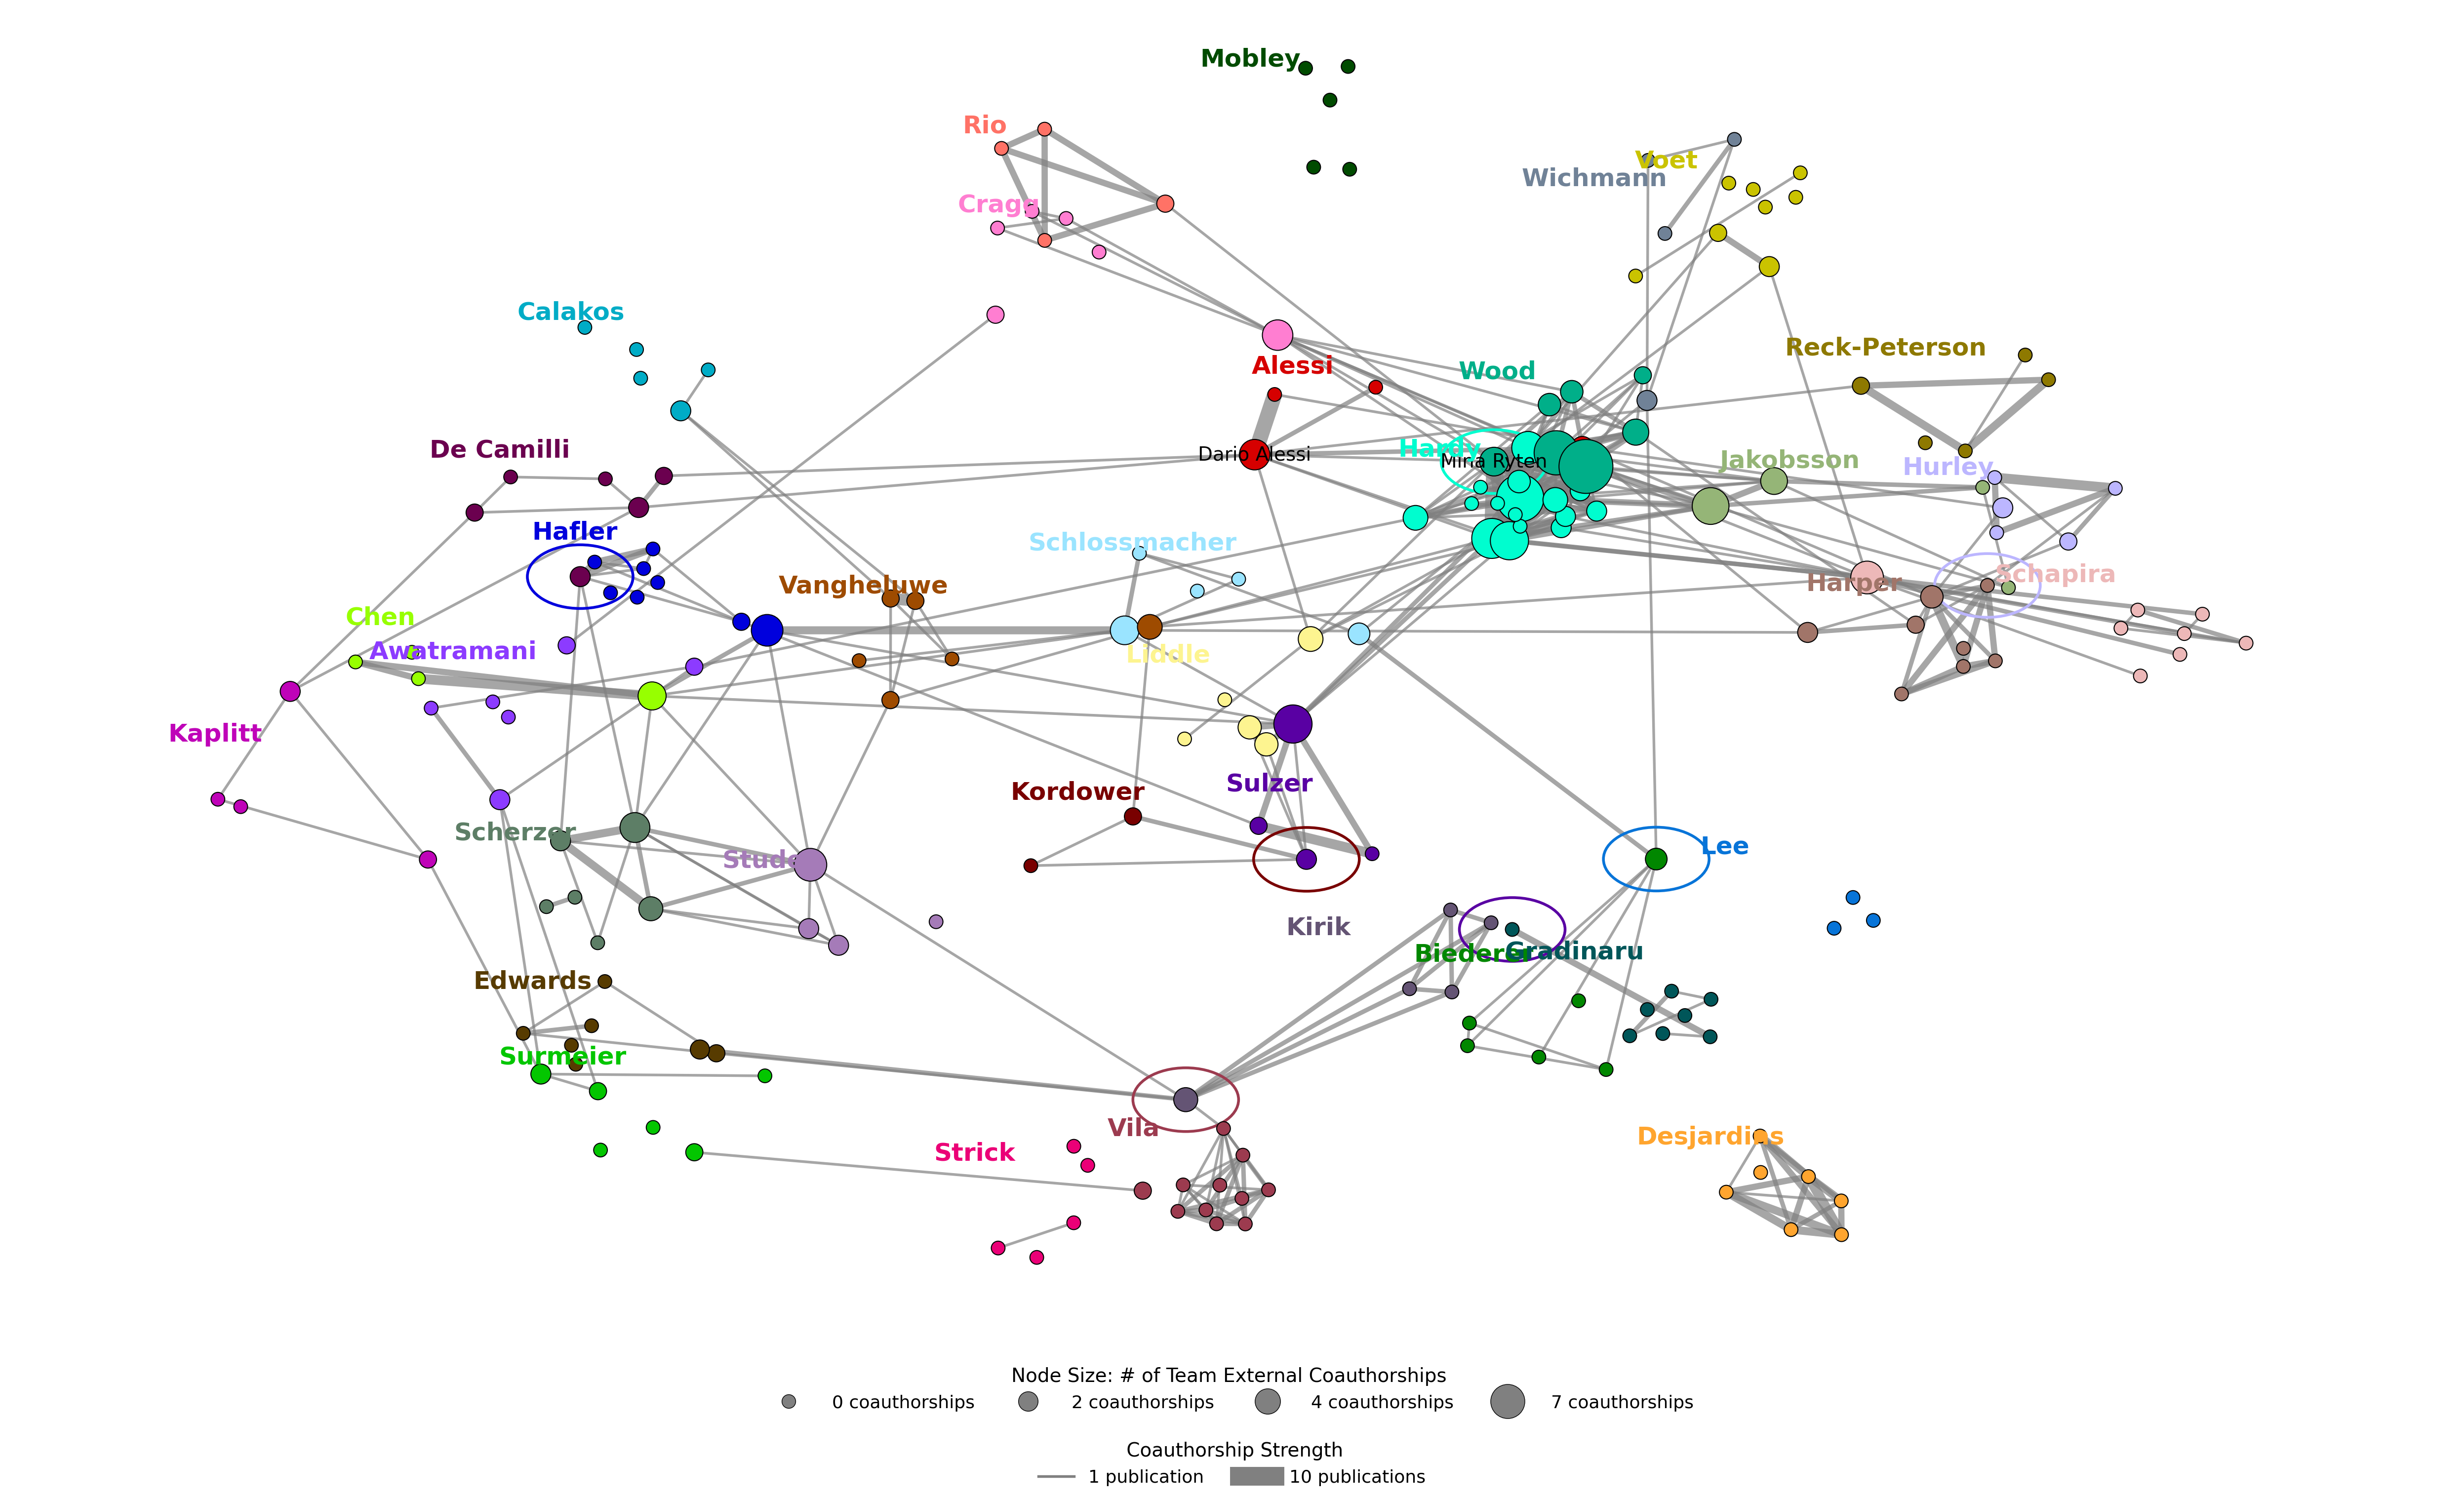

In [24]:


# Step 8: Plot
fig, ax = plt.subplots(figsize=(50, 30))

# Draw collaboration edges
nx.draw_networkx_edges(G, pos, edgelist=collab_edges, width=collab_weights_list, edge_color='gray', alpha=0.7, ax=ax)

# Normalize or scale node size (e.g., base size of 500, scaled by collab count)
base_node_size = 400
scaling_factor = 75  # adjust to control visual impact

node_sizes = [
    base_node_size + scaling_factor * external_team_collabs.get(node, 0)
    for node in G.nodes()
]


# Draw nodes (main circle)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=1.5, ax=ax)

# Draw multi-team rings
for node in G.nodes():
    teams = list(person_teams.get(node, []))[1:]  # Skip primary team
    for i, team in enumerate(teams):
        radius = 0.05 + 0.01 * i
        color = team_color_dict.get(team, "#888888")
        circle = plt.Circle(pos[node], radius, fill=False, edgecolor=color, linewidth=4)
        ax.add_patch(circle)

# Draw labels
# Define which nodes should be labeled
label_nodes = ["Dario Alessi", "Mina Ryten"]

# Build a dict with only those labels
custom_labels = {n: n for n in G.nodes if n in label_nodes}

# Draw only those labels
nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=28, ax=ax)

#nx.draw_networkx_labels(G, pos, font_size=14, ax=ax)

# Legend
unique_teams = list(team_color_dict.keys())

for team in unique_teams:
    # Get nodes belonging to this team
    team_nodes = [n for n in G.nodes if team in person_team_map.get(n, [])]
    
    if not team_nodes:
        continue
    
    # Compute average position of team nodes
    x_vals = [pos[n][0] for n in team_nodes]
    y_vals = [pos[n][1] for n in team_nodes]
    x_avg, y_avg = sum(x_vals)/len(x_vals) , sum(y_vals)/len(y_vals)
    display_name = team.replace("Team ", "")
    # Plot team label
    ax.text(
        x_avg - 0.075,
        y_avg + 0.075,  # Slight offset above the cluster
        display_name,
        color=team_color_dict[team],
        fontsize=36,
        fontweight='bold',
        ha='center'
    )


from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# Assume you already have a dictionary like:
# node_size_map = {node_name: size_value}
# and intra_collab_counts = {node_name: total_collabs}



# Flatten to get the total external collab count per person
collab_values = [count for count in external_team_collabs.values() if count]


# Fallback if empty
if not collab_values:
    collab_values = [0]

min_collabs = 0
max_collabs = 7
mid1 = min_collabs + (max_collabs - min_collabs) // 3
#mid2 = min_collabs + 2 * (max_collabs - min_collabs) // 3
mid2 = mid1*2

# Map to node sizes using your existing size logic
def scale_node_size(n_collabs):
    return 4 + n_collabs * 1.75  # Match your sizing logic

legend_nodes = [
    (min_collabs, scale_node_size(min_collabs)),
    (mid1, scale_node_size(mid1)),
    (mid2, scale_node_size(mid2)),
    (max_collabs, scale_node_size(max_collabs)),
]

import matplotlib.patches as mpatches

# Define legend values and corresponding sizes (example logic)
legend_collabs = [min_collabs, mid1, mid2, max_collabs]
legend_sizes = [20 + (val * 4.25) for val in legend_collabs] # switch to 20, 5.5 for all work types

# Create circle patches for the legend
node_legend_handles = [
    plt.Line2D([], [], marker='o', linestyle='None',
               markersize=size,  # scale appropriately
               markerfacecolor='gray', markeredgecolor='black',
               label=f'  {val} coauthorships')
    for val, size in zip(legend_collabs, legend_sizes)
]

# Add the node size legend (above edge legend)
legend1= ax.legend(
    handles=node_legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.045),  # Adjust y value for positioning above edge legend
    ncol=len(node_legend_handles),
    title='Node Size: # of Team External Coauthorships ',
    fontsize=26,
    title_fontsize=28,
    frameon=False
)


ax.add_artist(legend1)  # Add the node size legend first

# Now add the edge width legend below it (adjust anchor for spacing)
from matplotlib.lines import Line2D

edge_legend_handles = [
    Line2D([0], [0], color='gray', lw=w, label=f"{c} coauthorships")
    for c, w in [(min_collabs, 1), (max_collabs, 6)]
]

ax.legend(
    handles=edge_legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=26,
    title="\n Edge Weight (Coauthorship Strength)",
    title_fontsize=28,
    handletextpad=2.7,   # space between marker and text
    columnspacing=3.2    # space between columns (default is 2.0)
)


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# 1. Get min and max edge weights among collaboration edges
collab_weights = [d['weight'] for u, v, d in G.edges(data=True) if d['type'] in ('collab', 'both')]

min_w = 1
max_w = 10

# 2. Scale line widths same way you do when drawing edges
def scale_width(weight):
    # Replace with your actual width scaling logic if different
    return 1.3 + (weight / max_w) * 26  # Example: 0.5 to 6 point range

min_width = scale_width(min_w)
max_width = scale_width(max_w)

# 3. Create lines for legend
min_line = mlines.Line2D([], [], color='gray', linewidth=min_width, label=f"{min_w} publication{'s' if min_w > 1 else ''}")
max_line = mlines.Line2D([], [], color='gray', linewidth=max_width, label=f"{max_w} publications")

# 4. Place legend at bottom
plt.legend(
    handles=[min_line, max_line],
    title="\n Coauthorship Strength",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=False,
    fontsize=26,
    title_fontsize=28
)

# Title
#plt.title("Coauthorship Network Highlighting External Coauthorships", fontsize=48)
plt.axis('off')
plt.tight_layout()
plt.savefig('clean_coauthorship_network_external_collabs.pdf', bbox_inches='tight', dpi=300)
# Save graph to GEXF (recommended for Gephi)
#nx.write_gexf(G, "coauthorship_network.gexf")

# Alternatively, save as GraphML
#nx.write_graphml(G, "coauthorship_network.graphml")

plt.show()


### Internal Network

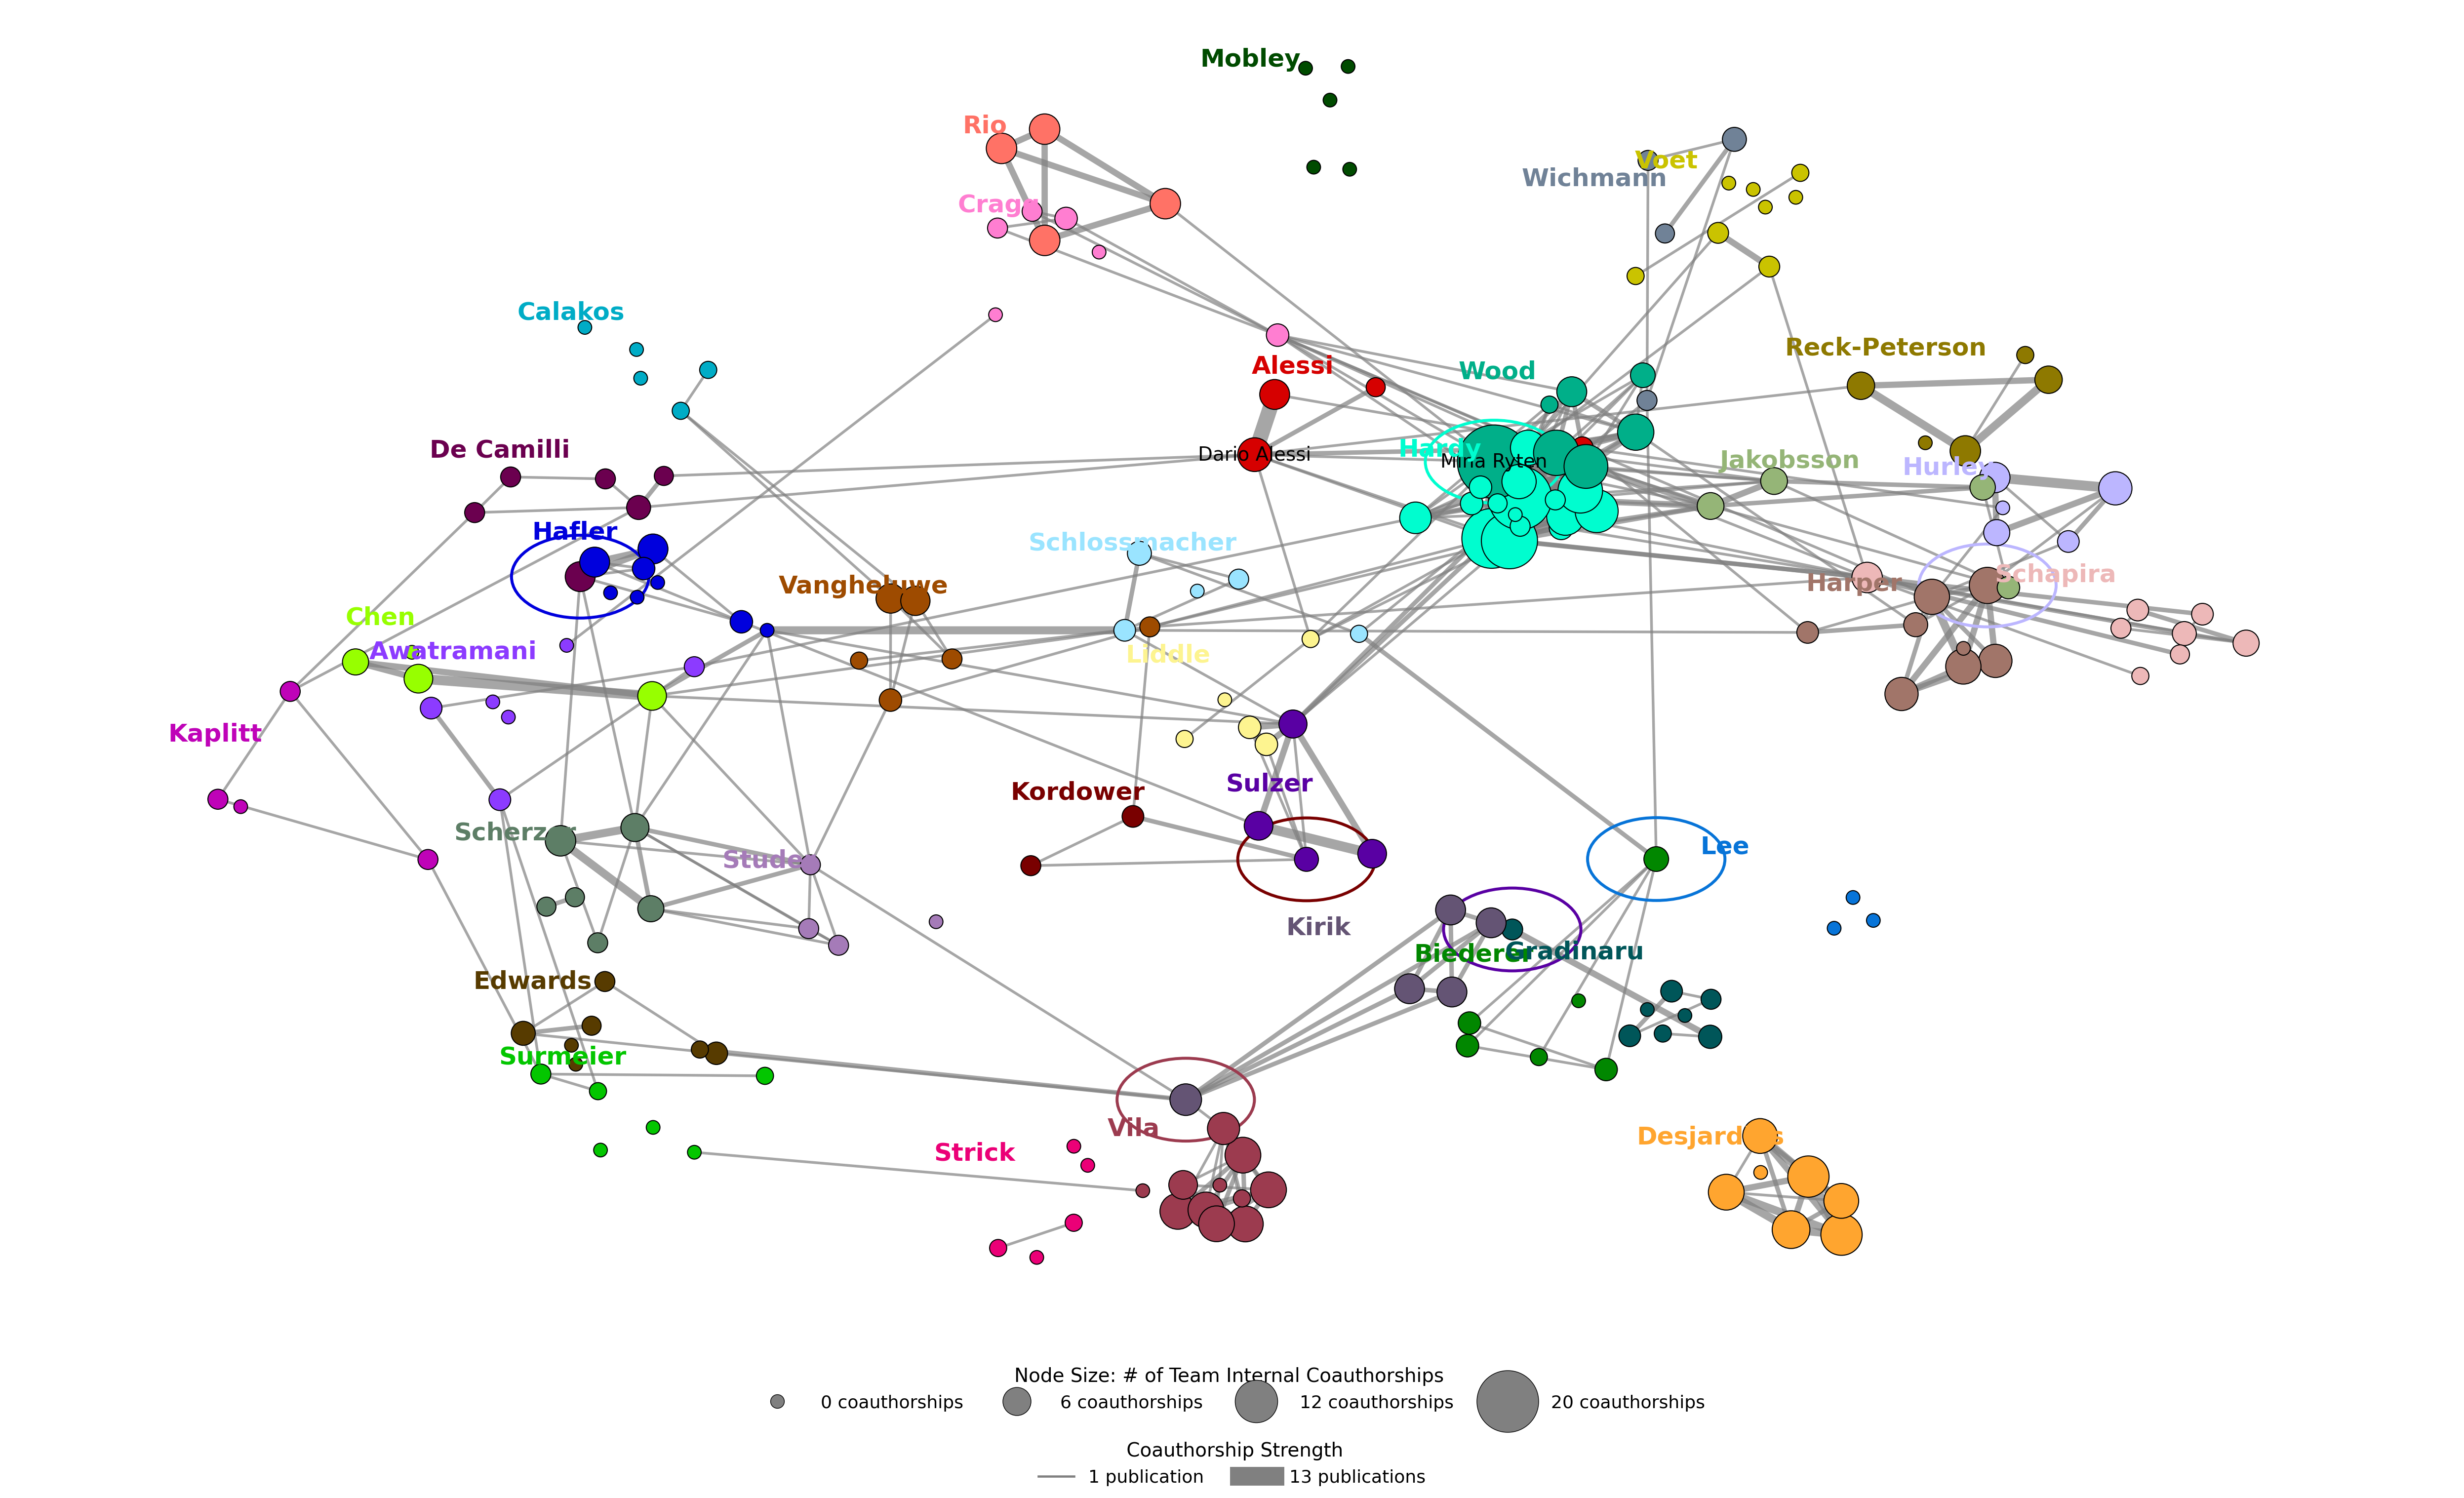

In [25]:


# Step 8: Plot
fig, ax = plt.subplots(figsize=(50, 30))

# Draw collaboration edges
nx.draw_networkx_edges(G, pos, edgelist=collab_edges, width=collab_weights_list, edge_color='gray', alpha=0.7, ax=ax)

# Normalize or scale node size (e.g., base size of 500, scaled by collab count)
base_node_size = 400
scaling_factor = 75  # adjust to control visual impact

node_sizes = [
    base_node_size + scaling_factor * internal_team_collabs.get(node, 0)
    for node in G.nodes()
]


# Draw nodes (main circle)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=1.5, ax=ax)

# Draw multi-team rings
for node in G.nodes():
    teams = list(person_teams.get(node, []))[1:]  # Skip primary team
    for i, team in enumerate(teams):
        radius = 0.065 + 0.03 * i
        color = team_color_dict.get(team, "#888888")
        circle = plt.Circle(pos[node], radius, fill=False, edgecolor=color, linewidth=4.3)
        ax.add_patch(circle)

# Draw labels
#nx.draw_networkx_labels(G, pos, font_size=14, ax=ax)
nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=28, ax=ax)
# Legend
unique_teams = list(team_color_dict.keys())

for team in unique_teams:
    # Get nodes belonging to this team
    team_nodes = [n for n in G.nodes if team in person_team_map.get(n, [])]
    
    if not team_nodes:
        continue
    
    # Compute average position of team nodes
    x_vals = [pos[n][0] for n in team_nodes]
    y_vals = [pos[n][1] for n in team_nodes]
    x_avg, y_avg = sum(x_vals)/len(x_vals) , sum(y_vals)/len(y_vals)
    display_name = team.replace("Team ", "")
    # Plot team label
    ax.text(
        x_avg - 0.075,
        y_avg + 0.075,  # Slight offset above the cluster
        display_name,
        color=team_color_dict[team],
        fontsize=36,
        fontweight='bold',
        ha='center'
    )


from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# Assume you already have a dictionary like:
# node_size_map = {node_name: size_value}
# and intra_collab_counts = {node_name: total_collabs}



# Flatten to get the total external collab count per person
collab_values = [count for count in internal_team_collabs.values() if count]


# Fallback if empty
if not collab_values:
    collab_values = [0]

min_collabs = 0
max_collabs = 20
mid1 = min_collabs + (max_collabs - min_collabs) // 3
#mid2 = min_collabs + 2 * (max_collabs - min_collabs) // 3
mid2 = mid1*2

# Map to node sizes using your existing size logic
def scale_node_size(n_collabs):
    return 4 + n_collabs * .5  # Match your sizing logic

legend_nodes = [
    (min_collabs, scale_node_size(min_collabs)),
    (mid1, scale_node_size(mid1)),
    (mid2, scale_node_size(mid2)),
    (max_collabs, scale_node_size(max_collabs)),
]

import matplotlib.patches as mpatches

# Define legend values and corresponding sizes (example logic)
legend_collabs = [min_collabs, mid1, mid2, max_collabs]
legend_sizes = [20 + (val * 3.5) for val in legend_collabs]

# Create circle patches for the legend
node_legend_handles = [
    plt.Line2D([], [], marker='o', linestyle='None',
               markersize=size,  # scale appropriately
               markerfacecolor='gray', markeredgecolor='black',
               label=f'  {val} coauthorships')
    for val, size in zip(legend_collabs, legend_sizes)
]

# Add the node size legend (above edge legend)
legend1= ax.legend(
    handles=node_legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.045),  # Adjust y value for positioning above edge legend
    ncol=len(node_legend_handles),
    title='Node Size: # of Team Internal Coauthorships ',
    fontsize=26,
    title_fontsize=28,
    frameon=False
)


ax.add_artist(legend1)  # Add the node size legend first

# Now add the edge width legend below it (adjust anchor for spacing)
from matplotlib.lines import Line2D

edge_legend_handles = [
    Line2D([0], [0], color='gray', lw=w, label=f"{c} coauthorships")
    for c, w in [(min_collabs, 1), (max_collabs, 6)]
]

ax.legend(
    handles=edge_legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=26,
    title="\n Edge Weight (Coauthorship Strength)",
    title_fontsize=28,
    handletextpad=2.7,   # space between marker and text
    columnspacing=3.2    # space between columns (default is 2.0)
)


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# 1. Get min and max edge weights among collaboration edges
collab_weights = [d['weight'] for u, v, d in G.edges(data=True) if d['type'] in ('collab', 'both')]

min_w = 1
max_w = 13

# 2. Scale line widths same way you do when drawing edges
def scale_width(weight):
    # Replace with your actual width scaling logic if different
    return 1.3 + (weight / max_w) * 26  # Example: 0.5 to 6 point range

min_width = scale_width(min_w)
max_width = scale_width(max_w)

# 3. Create lines for legend
min_line = mlines.Line2D([], [], color='gray', linewidth=min_width, label=f"{min_w} publication{'s' if min_w > 1 else ''}")
max_line = mlines.Line2D([], [], color='gray', linewidth=max_width, label=f"{max_w} publications")

# 4. Place legend at bottom
plt.legend(
    handles=[min_line, max_line],
    title="\n Coauthorship Strength",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=False,
    fontsize=26,
    title_fontsize=28
)

# Title
#plt.title("Coauthorship Network Highlighting Internal Coauthorships", fontsize=48)
plt.axis('off')
plt.tight_layout()
#plt.savefig('clean_coauthorship_network_internal_collabs.pdf', bbox_inches='tight', dpi=300)
# Save graph to GEXF (recommended for Gephi)
#nx.write_gexf(G, "coauthorship_network.gexf")

# Alternatively, save as GraphML
#nx.write_graphml(G, "coauthorship_network.graphml")

plt.show()


### Internal Coauthorship Network with Shapes to Distinguish Research Themes

In [26]:
# Example bins for internal coauthorship counts
size_bins = [0, 11, 23]  # adjust to your data range


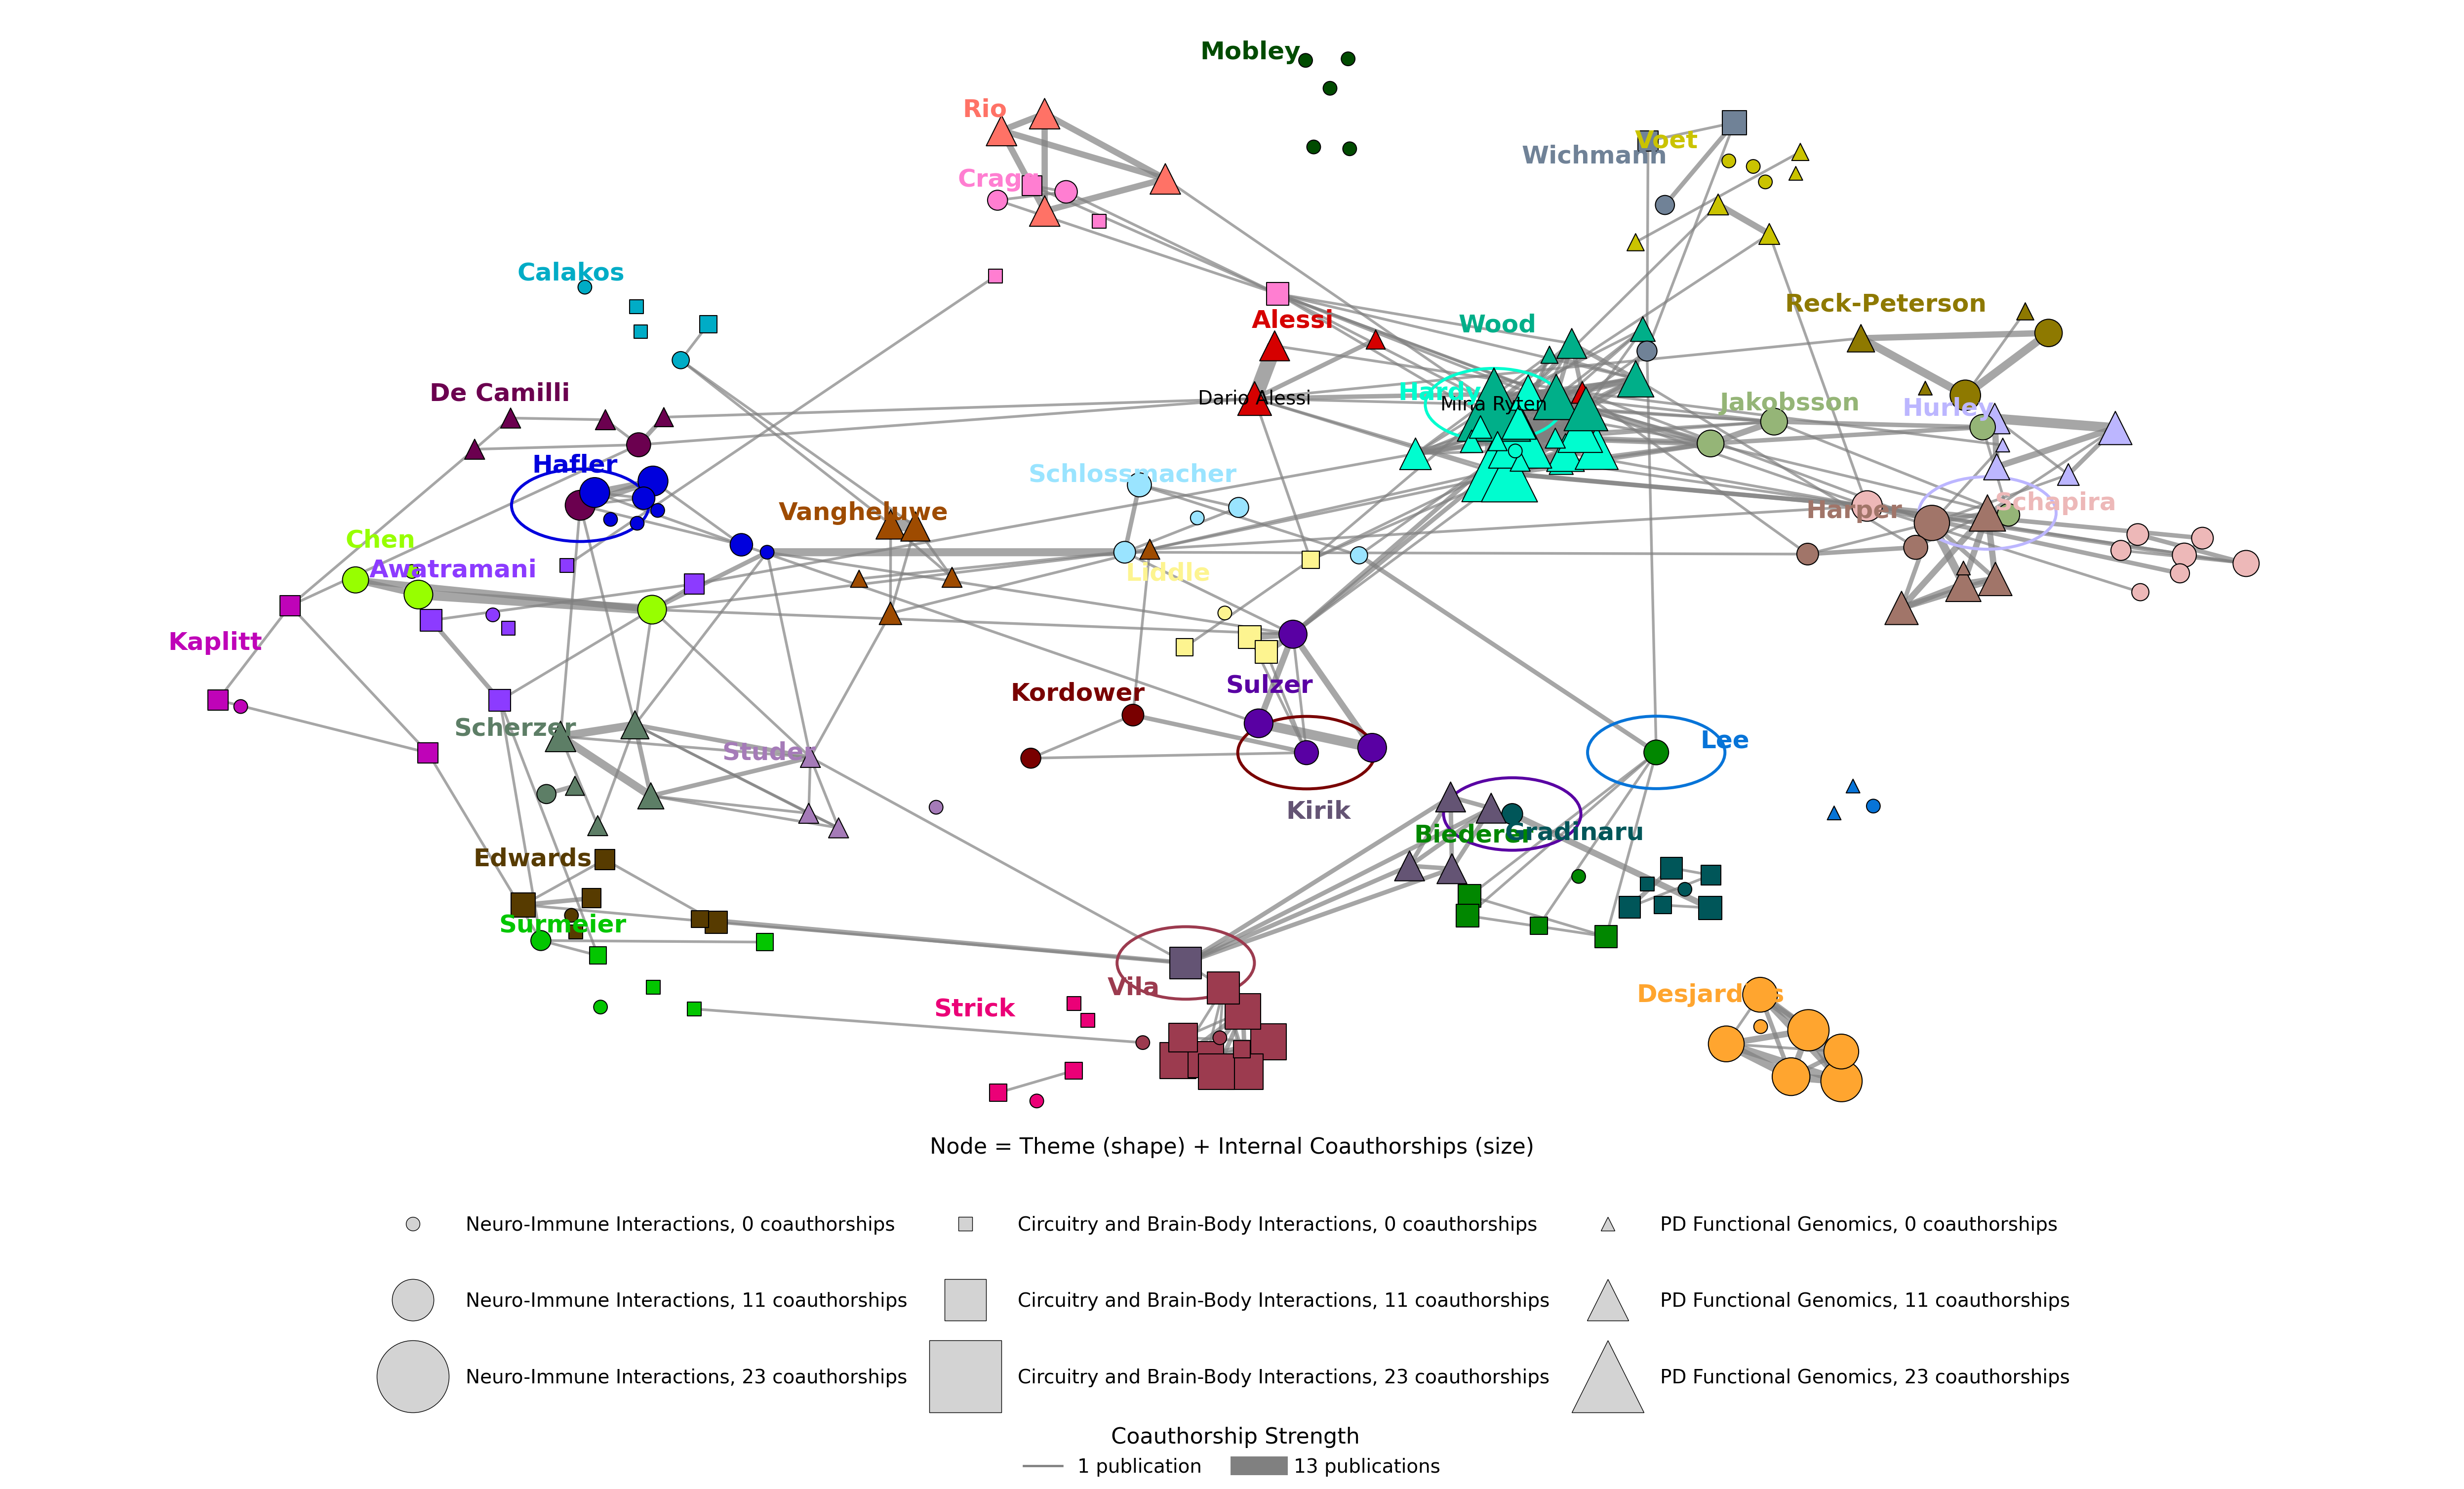

In [28]:


# Step 8: Plot
fig, ax = plt.subplots(figsize=(50, 30))

# Draw collaboration edges
nx.draw_networkx_edges(G, pos, edgelist=collab_edges, width=collab_weights_list, edge_color='gray', alpha=0.7, ax=ax)

# Normalize or scale node size (e.g., base size of 500, scaled by collab count)
base_node_size = 400
scaling_factor = 75  # adjust to control visual impact

node_sizes = [
    base_node_size + scaling_factor * internal_team_collabs.get(node, 0)
    for node in G.nodes()
]


# Draw nodes (main circle)
#nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=1.5, ax=ax)

# Draw multi-team rings
for node in G.nodes():
    teams = list(person_teams.get(node, []))[1:]  # Skip primary team
    for i, team in enumerate(teams):
        radius = 0.065 + 0.03 * i
        color = team_color_dict.get(team, "#888888")
        circle = plt.Circle(pos[node], radius, fill=False, edgecolor=color, linewidth=4.3)
        ax.add_patch(circle)


# --- Step X: Draw nodes with different shapes for research themes ---

# Map each person name → research theme
name_to_theme = dict(zip(main_pi_df['PersonName'], main_pi_df['research_theme']))

# Define theme-to-shape mapping
theme_shapes = {
    'Neuro-Immune Interactions': 'o',    # Circle
    'Circuitry and Brain-Body Interactions': 's',  # Square
    'PD Functional Genomics': '^',       # Triangle
}

# Optionally define fallback
default_shape = 'o'

# Prepare node attributes
node_size_map = {
    node: base_node_size + scaling_factor * internal_team_collabs.get(node, 0)
    for node in G.nodes()
}
node_color_map = dict(zip(G.nodes(), node_colors))

# Draw each shape separately
for theme, shape in theme_shapes.items():
    theme_nodes = [n for n in G.nodes() if name_to_theme.get(n) == theme]
    if not theme_nodes:
        continue
    
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=theme_nodes,
        node_color=[node_color_map[n] for n in theme_nodes],
        node_size=[node_size_map[n] for n in theme_nodes],
        node_shape=shape,
        edgecolors='black',
        linewidths=1.5,
        ax=ax
    )

# Draw any remaining nodes (missing theme info)
missing_theme_nodes = [n for n in G.nodes() if name_to_theme.get(n) not in theme_shapes]
if missing_theme_nodes:
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=missing_theme_nodes,
        node_color=[node_color_map[n] for n in missing_theme_nodes],
        node_size=[node_size_map[n] for n in missing_theme_nodes],
        node_shape=default_shape,
        edgecolors='black',
        linewidths=1.5,
        ax=ax
    )



# Draw labels
#nx.draw_networkx_labels(G, pos, font_size=14, ax=ax)
nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=28, ax=ax)
# Legend
unique_teams = list(team_color_dict.keys())

for team in unique_teams:
    # Get nodes belonging to this team
    team_nodes = [n for n in G.nodes if team in person_team_map.get(n, [])]
    
    if not team_nodes:
        continue
    
    # Compute average position of team nodes
    x_vals = [pos[n][0] for n in team_nodes]
    y_vals = [pos[n][1] for n in team_nodes]
    x_avg, y_avg = sum(x_vals)/len(x_vals) , sum(y_vals)/len(y_vals)
    display_name = team.replace("Team ", "")
    # Plot team label
    ax.text(
        x_avg - 0.075,
        y_avg + 0.075,  # Slight offset above the cluster
        display_name,
        color=team_color_dict[team],
        fontsize=36,
        fontweight='bold',
        ha='center'
    )


from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# Assume you already have a dictionary like:
# node_size_map = {node_name: size_value}
# and intra_collab_counts = {node_name: total_collabs}

import matplotlib.lines as mlines

# # --- Add shape legend (without overwriting other legends) ---
# shape_legend_handles = [
#     mlines.Line2D([], [], color='black', marker=shape, linestyle='None',
#                   markersize=20, markerfacecolor='gray', label=theme)
#     for theme, shape in theme_shapes.items()
# ]

# # Create a new legend
# shape_legend = ax.legend(
#     handles=shape_legend_handles,
#     loc='upper right',   # You can change this (e.g. 'upper left', 'center right')
#     fontsize=26,
#     title="Research Theme",
#     title_fontsize=28,
#     frameon=False
# )

# # Add it on top of existing legends
# ax.add_artist(shape_legend)



# # Flatten to get the total external collab count per person
# collab_values = [count for count in internal_team_collabs.values() if count]


# # Fallback if empty
# if not collab_values:
#     collab_values = [0]

# min_collabs = 0
# max_collabs = 20
# mid1 = min_collabs + (max_collabs - min_collabs) // 3
# #mid2 = min_collabs + 2 * (max_collabs - min_collabs) // 3
# mid2 = mid1*2

# # Map to node sizes using your existing size logic
# def scale_node_size(n_collabs):
#     return 4 + n_collabs * .5  # Match your sizing logic

# legend_nodes = [
#     (min_collabs, scale_node_size(min_collabs)),
#     (mid1, scale_node_size(mid1)),
#     (mid2, scale_node_size(mid2)),
#     (max_collabs, scale_node_size(max_collabs)),
# ]

import matplotlib.patches as mpatches

# # Define legend values and corresponding sizes (example logic)
# legend_collabs = [min_collabs, mid1, mid2, max_collabs]
# legend_sizes = [20 + (val * 3.5) for val in legend_collabs]

# # Create circle patches for the legend
# node_legend_handles = [
#     plt.Line2D([], [], marker='o', linestyle='None',
#                markersize=size,  # scale appropriately
#                markerfacecolor='gray', markeredgecolor='black',
#                label=f'  {val} coauthorships')
#     for val, size in zip(legend_collabs, legend_sizes)
# ]

# # Add the node size legend (above edge legend)
# legend1= ax.legend(
#     handles=node_legend_handles,
#     loc='lower center',
#     bbox_to_anchor=(0.5, -0.045),  # Adjust y value for positioning above edge legend
#     ncol=len(node_legend_handles),
#     title='Node Size: # of Team Internal Coauthorships ',
#     fontsize=26,
#     title_fontsize=28,
#     frameon=False
# )


# ax.add_artist(legend1)  # Add the node size legend first

def scale_node_size(n_collabs):
    return 20 + n_collabs * 3.7  # Match your sizing logic

from matplotlib.lines import Line2D

combined_handles = []

for theme, shape in theme_shapes.items():
    for s in size_bins:
        combined_handles.append(
            Line2D(
                [], [],
                color='gray',  # placeholder for now; color could be theme-specific if you want
                marker=shape,
                linestyle='None',
                markersize=scale_node_size(s),  # scale like in plot
                markerfacecolor='lightgray',
                markeredgecolor='black',
                label=f"{theme}, {s} coauthorships"
            )
        )


legend2 = ax.legend(
    handles=combined_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.175),
    ncol=len(size_bins),  # number of columns to make it compact
    fontsize=28,
    title="Node = Theme (shape) + Internal Coauthorships (size)",
    title_fontsize=32,
    frameon=False,
    labelspacing=3,              # increase space between rows (default=0.5)
    handletextpad=1.75  
)

ax.add_artist(legend2)

# Now add the edge width legend below it (adjust anchor for spacing)
from matplotlib.lines import Line2D


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# 1. Get min and max edge weights among collaboration edges
collab_weights = [d['weight'] for u, v, d in G.edges(data=True) if d['type'] in ('collab', 'both')]

min_w = 1
max_w = 13

# 2. Scale line widths same way you do when drawing edges
def scale_width(weight):
    # Replace with your actual width scaling logic if different
    return 1.3 + (weight / max_w) * 26  # Example: 0.5 to 6 point range

min_width = scale_width(min_w)
max_width = scale_width(max_w)

# 3. Create lines for legend
min_line = mlines.Line2D([], [], color='gray', linewidth=min_width, label=f"{min_w} publication{'s' if min_w > 1 else ''}")
max_line = mlines.Line2D([], [], color='gray', linewidth=max_width, label=f"{max_w} publications")

# 4. Place legend at bottom
plt.legend(
    handles=[min_line, max_line],
    title="\n Coauthorship Strength",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    frameon=False,
    fontsize=28,
    title_fontsize=32
)

# Title
#plt.title("Coauthorship Network Highlighting Internal Coauthorships", fontsize=48)
plt.axis('off')
plt.tight_layout()
plt.savefig('theme_shapes_coauthorship_network_internal_collabs.pdf', bbox_inches='tight', dpi=300)
# Save graph to GEXF (recommended for Gephi)
#nx.write_gexf(G, "coauthorship_network.gexf")

# Alternatively, save as GraphML
#nx.write_graphml(G, "coauthorship_network.graphml")

plt.show()


### Quantities between each type of research theme

In [29]:
main_pi_df.columns

Index(['Title', 'team_x', 'doi_pre', 'doi_pub', 'date_added_preprint',
       'date_added_publication', 'source_preprint', 'source_publication',
       'original', 'notes', 'Preprint in SF tracker',
       'publication in SF tracker', 'apc_amount', 'apc_status', 'OpenAlex_ID',
       'PersonOpenAlex_ID', 'PersonName', 'PersonOrcid', 'Role', 'Team',
       'IsCorrespondingAuthor', 'Supplement', 'Category', 'Round',
       'research_theme', 'Team_List'],
      dtype='object')

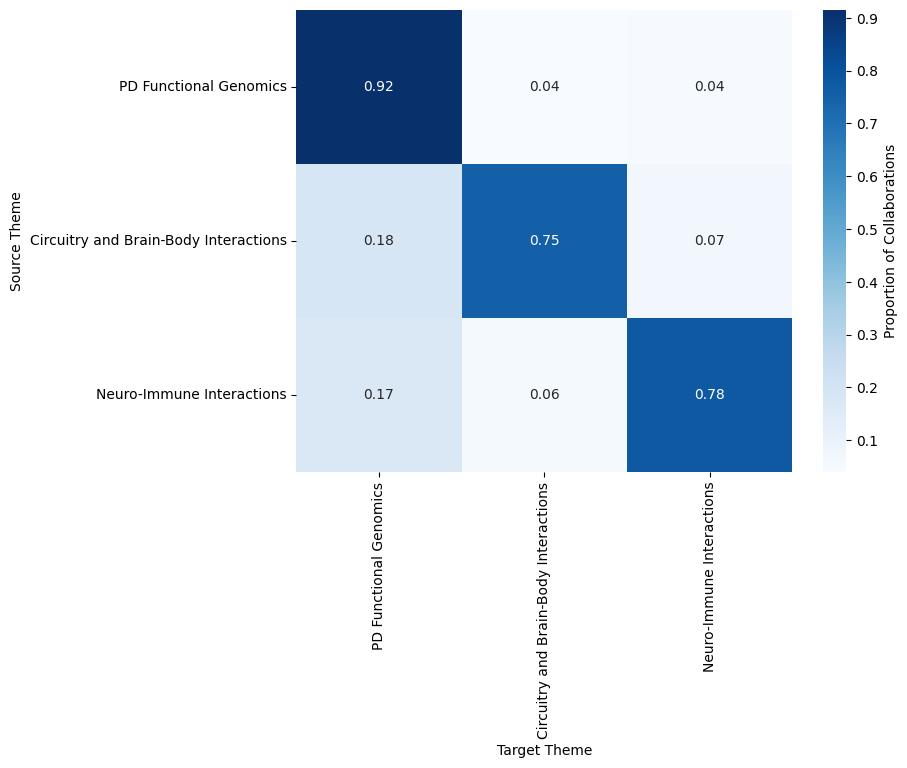

In [30]:
import pandas as pd
import itertools
import numpy as np

df = main_pi_df[['PersonName', 'OpenAlex_ID', 'research_theme']].dropna(subset=['research_theme'])
themes = df['research_theme'].unique()
theme_matrix = pd.DataFrame(0, index=themes, columns=themes, dtype=float)
# Group by OpenAlex_ID (i.e., each work)
for _, group in df.groupby('OpenAlex_ID'):
    # Get unique themes for all authors on this work
    people = group['PersonName'].tolist()
    themes_in_work = group['research_theme'].tolist()
    
    # Count all pairs of collaborators
    for theme_u, theme_v in itertools.combinations(themes_in_work, 2):
        theme_matrix.loc[theme_u, theme_v] += 1
        theme_matrix.loc[theme_v, theme_u] += 1  # symmetric, since undirected
theme_matrix_prop = theme_matrix.div(theme_matrix.sum(axis=1), axis=0)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    theme_matrix_prop,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={'label': 'Proportion of Collaborations'}
)
#plt.title("Proportion of Collaborations by Research Theme", fontsize=16)
plt.xlabel("Target Theme")
plt.ylabel("Source Theme")
plt.savefig('research_theme_connections_heatmap.pdf', bbox_inches='tight', dpi=300)
plt.show()


## Nx Density Analysis

### prep cell

In [31]:
import itertools
import pandas as pd
import numpy as np

# Step 1: person → teams
person_to_teams = main_pi_df.groupby("PersonName")["Team"].unique().to_dict()

# Step 2: collect works
works = main_pi_df.groupby("OpenAlex_ID")["PersonName"].unique().to_dict()

# Step 3: team members and supplement
team_to_people = main_pi_df.groupby("Team")["PersonName"].apply(set).to_dict()
team_to_supplement = main_pi_df.drop_duplicates("Team").set_index("Team")["Supplement"].to_dict()

# Step 4: determine uniform Nx range
max_team_size = max(len(members) for members in team_to_people.values())
Nx_range = range(2,9+1)

# Step 5: initialize team_connections
team_connections = {team: {n: set() for n in Nx_range} for team in team_to_people}

# Step 6: process works
for work_id, people in works.items():
    for team, members in team_to_people.items():
        team_members_on_work = [p for p in people if team in person_to_teams.get(p, [])]
        s = len(team_members_on_work)
        if s >= 2:
            new_pairs = set(itertools.combinations(sorted(team_members_on_work), 2))
            # update all Nx >= s
            for n in Nx_range:
                if n >= s:
                    team_connections[team][n].update(new_pairs)

# Step 7: compute densities and extend last value if needed
team_densities = []
for team, Nx_dict in team_connections.items():
    members = team_to_people[team]
    k = len(members)
    denom = k*(k-1)/2 if k>1 else 1
    last_density = 0
    for n in Nx_range:
        num_pairs = len(Nx_dict[n])
        density = num_pairs / denom
        if density < last_density:
            density = last_density  # cumulative behavior ensures monotone
        last_density = density
        team_densities.append({
            "Team": team,
            "Supplement": team_to_supplement[team],
            "N": n,
            "Density": density
        })

density_df = pd.DataFrame(team_densities)


### Graph cells

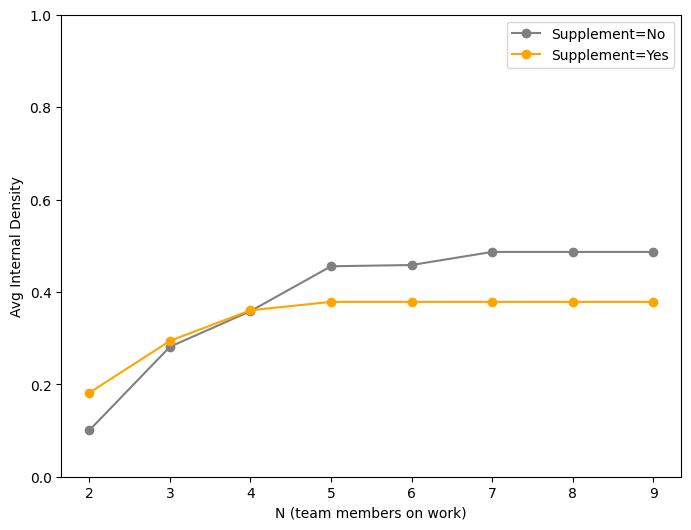

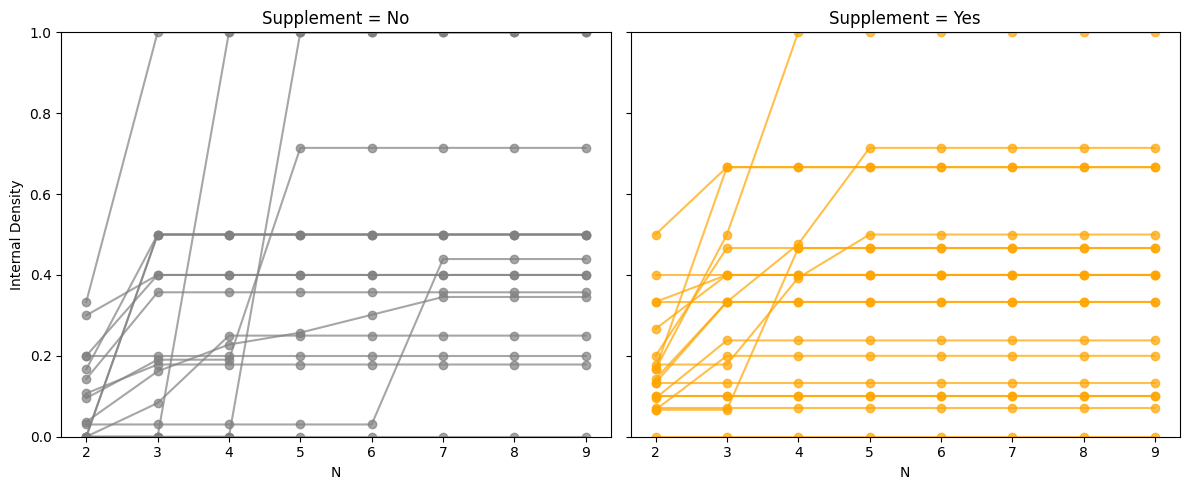

In [32]:
import matplotlib.pyplot as plt

colors = {"Yes": "orange", "No": "grey"}

# Average by supplement
plt.figure(figsize=(8,6))
for supp, group in density_df.groupby("Supplement"):
    avg = group.groupby("N")["Density"].mean()
    plt.plot(avg.index, avg.values, marker="o", color=colors[supp], label=f"Supplement={supp}")
plt.xlabel("N (team members on work)")
plt.ylabel("Avg Internal Density")
#plt.title("Average Internal Density by Supplement")
plt.xticks(Nx_range)
plt.ylim(0,1)
plt.legend()
#plt.savefig("nx_internal_density_by_supplement.pdf", dpi=300)
plt.show()

# Split by supplement group
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
for ax, (supp, group) in zip(axes, density_df.groupby("Supplement")):
    for team, team_group in group.groupby("Team"):
        ax.plot(team_group["N"], team_group["Density"], marker="o", alpha=0.7, color=colors[supp])
    ax.set_title(f"Supplement = {supp}")
    ax.set_xlabel("N")
    ax.set_xticks(Nx_range)
axes[0].set_ylabel("Internal Density")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("nx_internal_density_by_team_and_supplement.pdf", dpi=300)
plt.show()


Average density graph with standard error of mean

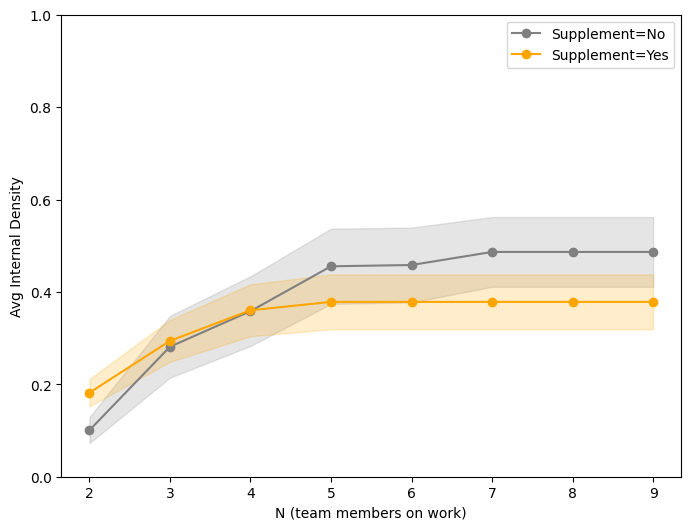

In [33]:
import matplotlib.pyplot as plt

colors = {"Yes": "orange", "No": "grey"}

plt.figure(figsize=(8,6))

for supp, group in density_df.groupby("Supplement"):
    grouped = group.groupby("N")["Density"]
    mean = grouped.mean()
    sem = grouped.sem()  # standard error of the mean
    
    # Plot the mean line
    plt.plot(mean.index, mean.values, marker="o", color=colors[supp], label=f"Supplement={supp}")
    
    # Add SEM shading
    plt.fill_between(mean.index,
                     mean - sem,
                     mean + sem,
                     color=colors[supp],
                     alpha=0.2)

plt.xlabel("N (team members on work)")
plt.ylabel("Avg Internal Density")
#plt.title("Average Internal Density by Supplement (± Standard Error of the Mean)")
plt.xticks(Nx_range)
plt.ylim(0,1)
plt.legend()
plt.savefig("nx_internal_density_by_supplement_with_sem.pdf", dpi=300)
plt.show()


In [64]:
from scipy.stats import mannwhitneyu

# Work on a copy so we don't modify the original dataframe
df_temp = density_df.copy()

# Ensure we have a 'Supplement' column. If missing, try to map it from main_pi_df via Team.
if 'Supplement' not in df_temp.columns:
    if 'Team' in df_temp.columns and 'Team' in main_pi_df.columns:
        supp_map = main_pi_df.drop_duplicates('Team').set_index('Team')['Supplement'].to_dict()
        df_temp['Supplement'] = df_temp['Team'].map(supp_map)
    else:
        df_temp['Supplement'] = pd.NA

results = []
for n, group in df_temp.groupby("N"):
    supp_yes = group.loc[group["Supplement"] == "Yes", "Density"]
    supp_no  = group.loc[group["Supplement"] == "No", "Density"]

    # If either group is empty, skip the test and record NaNs
    if len(supp_yes) < 1 or len(supp_no) < 1:
        stat, pval = (pd.NA, pd.NA)
    else:
        try:
            stat, pval = mannwhitneyu(supp_yes, supp_no, alternative="two-sided")
        except Exception:
            stat, pval = (pd.NA, pd.NA)

    results.append({"N": int(n), "U-stat": stat, "p-value": pval})

mw_df = pd.DataFrame(results)
print(mw_df)


   N  U-stat   p-value
0  2   209.0  0.060035
1  3   164.0  0.702395
2  4   156.5  0.894353
3  5   131.5  0.506398
4  6   131.5  0.506398
5  7   118.5  0.272924
6  8   118.5  0.272924
7  9   118.5  0.272924


## Nx by research theme

In [34]:
import itertools
import pandas as pd
import numpy as np

# Step 1: person → teams
person_to_teams = main_pi_df.groupby("PersonName")["Team"].unique().to_dict()

# Step 2: collect works
works = main_pi_df.groupby("OpenAlex_ID")["PersonName"].unique().to_dict()

# Step 3: team members and supplement
team_to_people = main_pi_df.groupby("Team")["PersonName"].apply(set).to_dict()
team_to_supplement = main_pi_df.drop_duplicates("Team").set_index("Team")["research_theme"].to_dict()

# Step 4: determine uniform Nx range
max_team_size = max(len(members) for members in team_to_people.values())
Nx_range = range(2,9+1)

# Step 5: initialize team_connections
team_connections = {team: {n: set() for n in Nx_range} for team in team_to_people}

# Step 6: process works
for work_id, people in works.items():
    for team, members in team_to_people.items():
        team_members_on_work = [p for p in people if team in person_to_teams.get(p, [])]
        s = len(team_members_on_work)
        if s >= 2:
            new_pairs = set(itertools.combinations(sorted(team_members_on_work), 2))
            # update all Nx >= s
            for n in Nx_range:
                if n >= s:
                    team_connections[team][n].update(new_pairs)

# Step 7: compute densities and extend last value if needed
team_densities = []
for team, Nx_dict in team_connections.items():
    members = team_to_people[team]
    k = len(members)
    denom = k*(k-1)/2 if k>1 else 1
    last_density = 0
    for n in Nx_range:
        num_pairs = len(Nx_dict[n])
        density = num_pairs / denom
        if density < last_density:
            density = last_density  # cumulative behavior ensures monotone
        last_density = density
        team_densities.append({
            "Team": team,
            "research_theme": team_to_supplement[team],
            "N": n,
            "Density": density
        })

density_df = pd.DataFrame(team_densities)


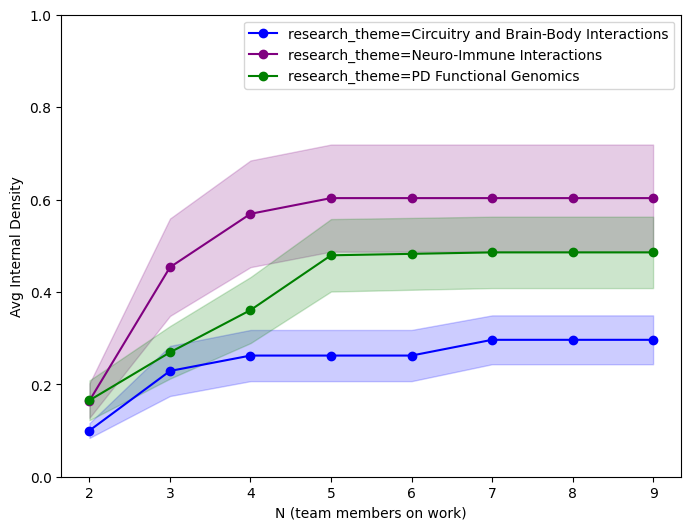

In [35]:
import matplotlib.pyplot as plt

colors = {"PD Functional Genomics": "green", "Circuitry and Brain-Body Interactions": "blue", "Neuro-Immune Interactions":"purple"}

plt.figure(figsize=(8,6))

for supp, group in density_df.groupby("research_theme"):
    grouped = group.groupby("N")["Density"]
    mean = grouped.mean()
    sem = grouped.sem()  # standard error of the mean
    
    # Plot the mean line
    plt.plot(mean.index, mean.values, marker="o", color=colors[supp], label=f"research_theme={supp}")
    
    # Add SEM shading
    plt.fill_between(mean.index,
                     mean - sem,
                     mean + sem,
                     color=colors[supp],
                     alpha=0.2)

plt.xlabel("N (team members on work)")
plt.ylabel("Avg Internal Density")
#plt.title("Average Internal Density by research_theme (± Standard Error of the Mean)")
plt.xticks(Nx_range)
plt.ylim(0,1)
plt.legend()
plt.savefig("rt_nx_internal_density_by_supplement_with_sem.pdf", dpi=300)
plt.show()


## Fraction of External Collaborators by Team

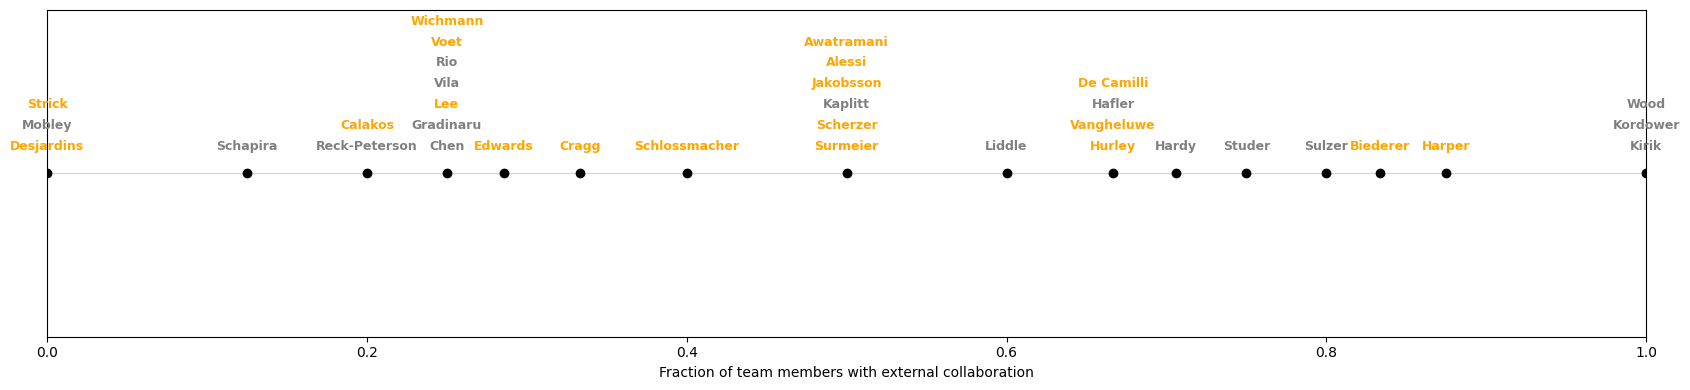

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Clean df
df = main_pi_df.copy()
df["OpenAlex_ID"] = df["OpenAlex_ID"].replace("", np.nan)

# Step 1: find external collaborators
external_collab = {}
for work_id, group in df.dropna(subset=["OpenAlex_ID"]).groupby("OpenAlex_ID"):
    teams_in_work = group["Team"].unique()
    if len(teams_in_work) > 1:  # external collab happens
        for person in group["PersonName"]:
            external_collab[person] = True

# Step 2: compute fraction for each team
team_fractions = []
for team, group in df.groupby("Team"):
    members = group["PersonName"].unique()
    total = len(members)
    externals = sum(1 for p in members if external_collab.get(p, False))
    frac = externals / total if total > 0 else 0
    supp_val = group["Supplement"].iloc[0]
    team_fractions.append({
        "Team": team,
        "Fraction": frac,
        "Supplement": supp_val
    })

team_frac_df = pd.DataFrame(team_fractions).sort_values("Fraction")

# Step 3: plot with stacked labels
colors = {"Yes": "orange", "No": "grey"}

plt.figure(figsize=(17, 4))
plt.hlines(0, 0, 1, color="lightgrey", linewidth=0.8)  # baseline

# Track how many labels already plotted at each fraction
fraction_counts = {}

for _, row in team_frac_df.iterrows():
    frac = row["Fraction"]
    team = row["Team"]
    supp = row["Supplement"]

    # Plot the dot only once per fraction
    if frac not in fraction_counts:
        plt.plot(frac, 0, "o", color="black")
        fraction_counts[frac] = 0

    # Offset for stacking team names
    offset = 0.007 * (fraction_counts[frac] + 1)
    plt.text(frac, offset, team, color=colors.get(supp, "grey"),
             ha="center", va="bottom", fontsize=9, fontweight="bold")
    fraction_counts[frac] += 1

plt.yticks([])
plt.xlabel("Fraction of team members with external collaboration")
#plt.title("Proportion of People with External Collaborations by Team")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig("fraction_external_collaborators_by_team.pdf", dpi=300)
plt.show()


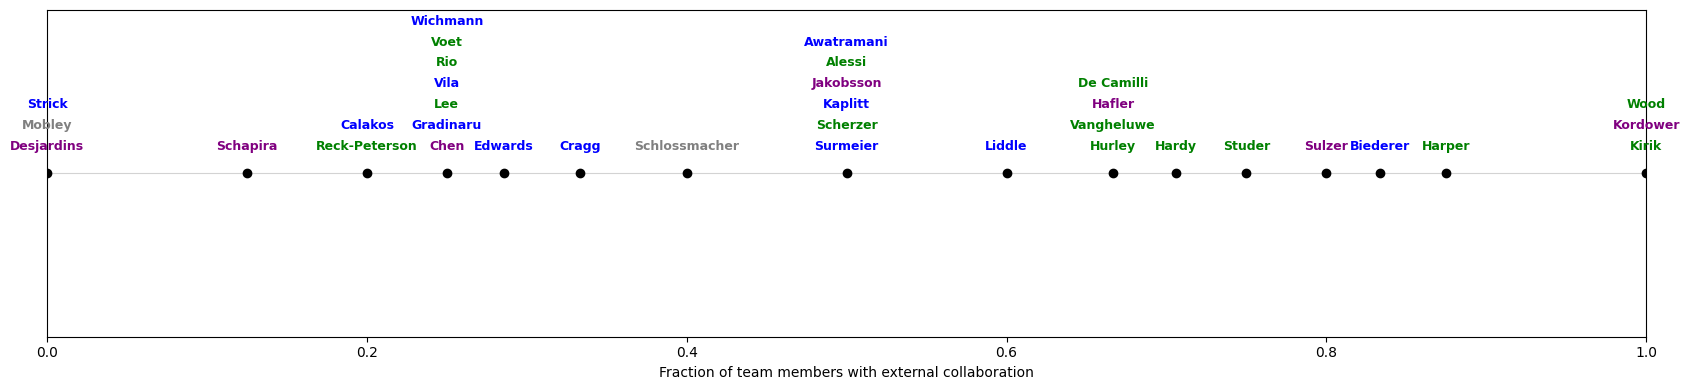

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Clean df
df = main_pi_df.copy()
df["OpenAlex_ID"] = df["OpenAlex_ID"].replace("", np.nan)

# Step 1: find external collaborators
external_collab = {}
for work_id, group in df.dropna(subset=["OpenAlex_ID"]).groupby("OpenAlex_ID"):
    teams_in_work = group["Team"].unique()
    if len(teams_in_work) > 1:  # external collab happens
        for person in group["PersonName"]:
            external_collab[person] = True

# Step 2: compute fraction for each team
team_fractions = []
for team, group in df.groupby("Team"):
    members = group["PersonName"].unique()
    total = len(members)
    externals = sum(1 for p in members if external_collab.get(p, False))
    frac = externals / total if total > 0 else 0
    supp_val = group["research_theme"].iloc[0]
    team_fractions.append({
        "Team": team,
        "Fraction": frac,
        "research_theme": supp_val
    })

team_frac_df = pd.DataFrame(team_fractions).sort_values("Fraction")

# Step 3: plot with stacked labels
colors = {"PD Functional Genomics": "green", "Circuitry and Brain-Body Interactions": "blue", "Neuro-Immune Interactions":"purple"}

plt.figure(figsize=(17, 4))
plt.hlines(0, 0, 1, color="lightgrey", linewidth=0.8)  # baseline

# Track how many labels already plotted at each fraction
fraction_counts = {}

for _, row in team_frac_df.iterrows():
    frac = row["Fraction"]
    team = row["Team"]
    supp = row["research_theme"]

    # Plot the dot only once per fraction
    if frac not in fraction_counts:
        plt.plot(frac, 0, "o", color="black")
        fraction_counts[frac] = 0

    # Offset for stacking team names
    offset = 0.007 * (fraction_counts[frac] + 1)
    plt.text(frac, offset, team, color=colors.get(supp, "grey"),
             ha="center", va="bottom", fontsize=9, fontweight="bold")
    fraction_counts[frac] += 1

plt.yticks([])
plt.xlabel("Fraction of team members with external collaboration")
#plt.title("Proportion of People with External Collaborations by Team")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig("rt_fraction_external_collaborators_by_team.pdf", dpi=300)
plt.show()


In [38]:
main_pi_df['research_theme'].value_counts()

research_theme
PD Functional Genomics                   464
Circuitry and Brain-Body Interactions    194
Neuro-Immune Interactions                152
Name: count, dtype: int64

# Internal Collaboration Scale with Example Team Graphs

In [39]:
main_pi_df.columns

Index(['Title', 'team_x', 'doi_pre', 'doi_pub', 'date_added_preprint',
       'date_added_publication', 'source_preprint', 'source_publication',
       'original', 'notes', 'Preprint in SF tracker',
       'publication in SF tracker', 'apc_amount', 'apc_status', 'OpenAlex_ID',
       'PersonOpenAlex_ID', 'PersonName', 'PersonOrcid', 'Role', 'Team',
       'IsCorrespondingAuthor', 'Supplement', 'Category', 'Round',
       'research_theme', 'Team_List'],
      dtype='object')

In [40]:
import pandas as pd
from itertools import combinations

# Drop rows with missing person or team info
filtered_df = main_pi_df.dropna(subset=['Team', 'OpenAlex_ID', 'PersonOpenAlex_ID'])

results = []

# Get list of unique teams
teams = main_pi_df['Team'].dropna().unique()

for team in teams:
    team_df = main_pi_df[main_pi_df['Team'] == team]

    # Unique people on the team (using ListofAlexIds to identify individuals)
    people = team_df['PersonOpenAlex_ID'].dropna().unique().tolist()
    team_size = len(people)

    if team_size < 2:
        # Skip teams that can't form pairs
        continue

    # All possible pairs of individuals (undirected, no self-pairs)
    possible_pairs = list(combinations(sorted(people), 2))
    max_connections = len(possible_pairs)

    # Create a mapping from publication to all individuals on that team in that pub
    team_pubs = team_df.dropna(subset=['OpenAlex_ID'])
    pub_to_people = team_pubs.groupby('OpenAlex_ID')['PersonOpenAlex_ID'].unique().to_dict()

    # Store all actual pairs who collaborated
    actual_pairs = set()
    for people_list in pub_to_people.values():
        # Get all pairs of people from this publication
        pub_pairs = combinations(sorted(set(people_list)), 2)
        for pair in pub_pairs:
            if pair[0] in people and pair[1] in people:
                actual_pairs.add(pair)

    actual_connections = len(actual_pairs)
    collab_score = actual_connections / max_connections if max_connections > 0 else 0

    results.append({
        'Team': team,
        'TeamSize': team_size,
        'MaxConnections': max_connections,
        'ActualConnections': actual_connections,
        'CollabScore': round(collab_score, 3)
    })

# Final result DataFrame
collab_df = pd.DataFrame(results)


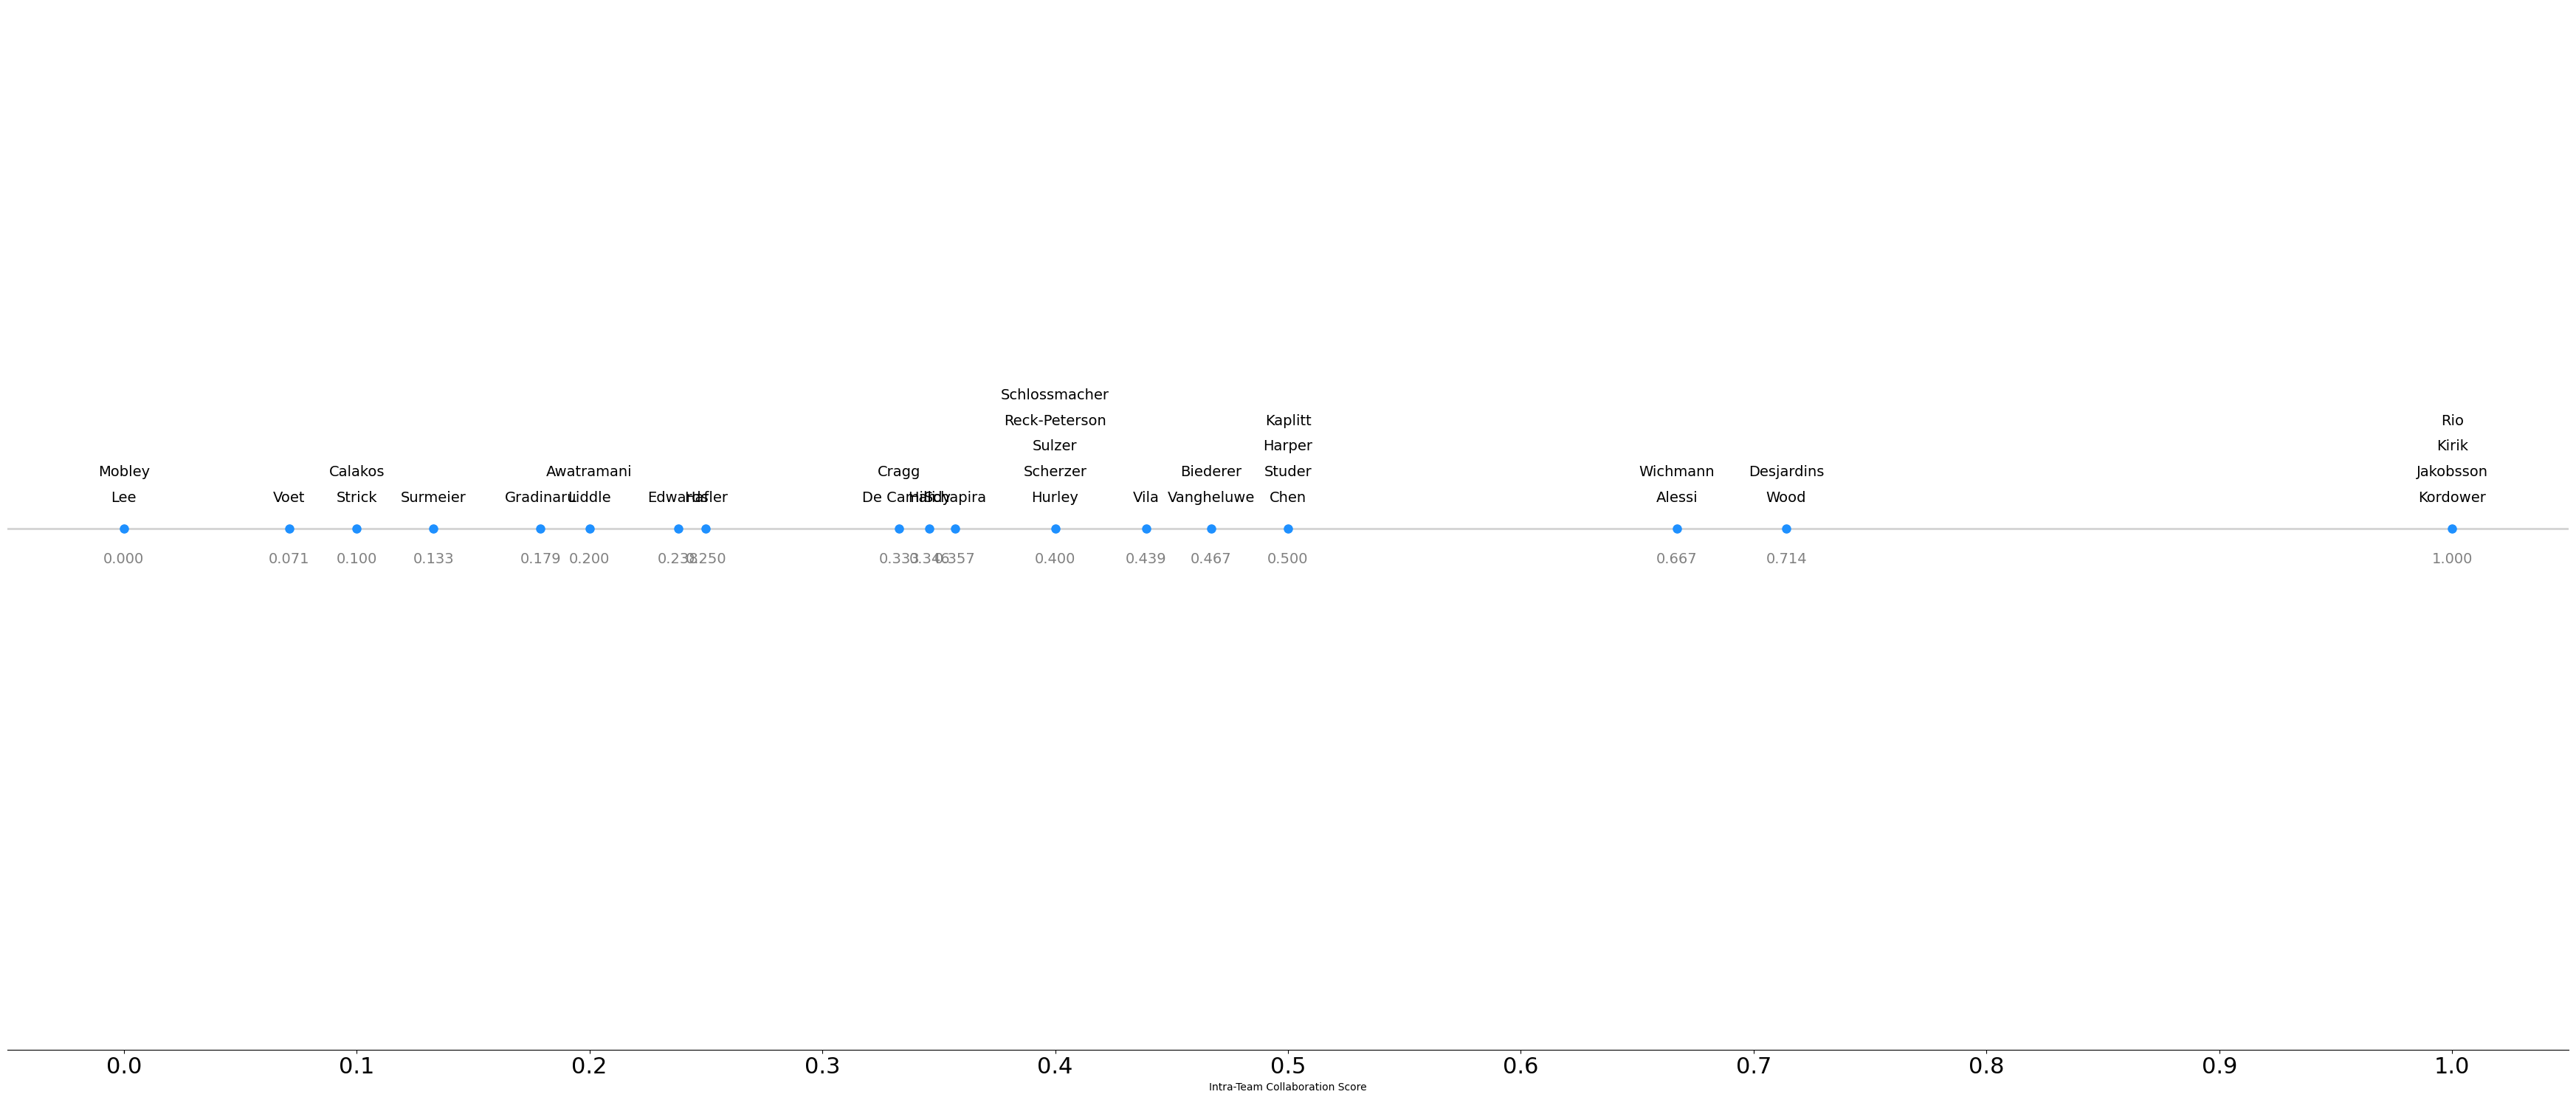

In [41]:
import matplotlib.pyplot as plt

# Group teams by real collaboration score
score_to_teams = collab_df.groupby('CollabScore')['Team'].apply(list).sort_index()

# Set up a wide figure to stretch out the 0–1 scale
plt.figure(figsize=(35, 15))
plt.axhline(0, color='lightgray', linewidth=2)

# Plot one dot per score and stack team names with reduced spacing
for score, teams in score_to_teams.items():
    plt.plot(score, 0, 'o', color='dodgerblue', markersize=8)
    plt.text(score, -0.0025, f"{score:.3f}", ha='center', va='top', fontsize=14, color='gray')



    for i, team in enumerate(teams):
        # Stack names with reduced vertical gap (0.04 instead of 0.15)
        plt.text(score, 0.0025 + i * 0.0027, team, ha='center', va='bottom', fontsize=14)

# Remove plot spines (the box frame)
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)


# Format x-axis
plt.xlim(-0.05, 1.05)
plt.xticks([i / 10 for i in range(11)], fontsize=22)
plt.yticks([])

plt.xlabel("Intra-Team Collaboration Score")
plt.tight_layout()
plt.savefig('intra_team_collaboration_scores_on_scale_needs_images.png', bbox_inches='tight', dpi=300)
plt.show()


In [42]:
main_pi_df.columns

Index(['Title', 'team_x', 'doi_pre', 'doi_pub', 'date_added_preprint',
       'date_added_publication', 'source_preprint', 'source_publication',
       'original', 'notes', 'Preprint in SF tracker',
       'publication in SF tracker', 'apc_amount', 'apc_status', 'OpenAlex_ID',
       'PersonOpenAlex_ID', 'PersonName', 'PersonOrcid', 'Role', 'Team',
       'IsCorrespondingAuthor', 'Supplement', 'Category', 'Round',
       'research_theme', 'Team_List'],
      dtype='object')

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_team_internal_network(team_name, full_graph, main_pi_df, color_palette, color, score):
    # --- Map teams to consistent colors ---
    unique_teams = sorted(main_pi_df['Team'].dropna().unique())
    team_color_map = {team: color_palette[i] for i, team in enumerate(unique_teams)}

    # --- Filter people from selected team ---
    team_members = main_pi_df[main_pi_df['Team'] == team_name]['PersonName'].unique()

    # --- Create subgraph with only nodes from the team ---
    sub_nodes = [n for n in full_graph.nodes if n in team_members]
    
    # Keep only internal collaboration edges
    internal_edges = [
        (u, v) for u, v, d in full_graph.edges(sub_nodes, data=True)
        if d['type'] in ('collab', 'both') and u in sub_nodes and v in sub_nodes
    ]

    team_subgraph = nx.Graph()
    team_subgraph.add_nodes_from(sub_nodes)
    for u, v in internal_edges:
        weight = full_graph[u][v].get('weight', 1)
        team_subgraph.add_edge(u, v, weight=weight)

    # --- Node positioning ---
    pos = nx.spring_layout(team_subgraph,k=2, seed=42)

    # --- Node sizes based on internal collab weight ---
    collab_counts = {
        node: sum(
            team_subgraph[node][nbr].get('weight', 1)
            for nbr in team_subgraph.neighbors(node)
        )
        for node in team_subgraph.nodes()
    }
    node_sizes = [500 + 30 * collab_counts.get(n, 0) for n in team_subgraph.nodes()]

    # --- Draw the network ---
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_edges(
        team_subgraph,
        pos,
        width=[team_subgraph[u][v]['weight'] for u, v in team_subgraph.edges()],
        edge_color='gray'
    )
    nx.draw_networkx_nodes(
        team_subgraph,
        pos,
        node_color=color,
        node_size=node_sizes
    )
    nx.draw_networkx_labels(
        team_subgraph,
        pos,
        font_size=10
    )

    plt.title(f"Internal Collaborations – {team_name}", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{color}_{team_name}_team_internal_collab_{score}.png', bbox_inches='tight', dpi=300)
    plt.show()


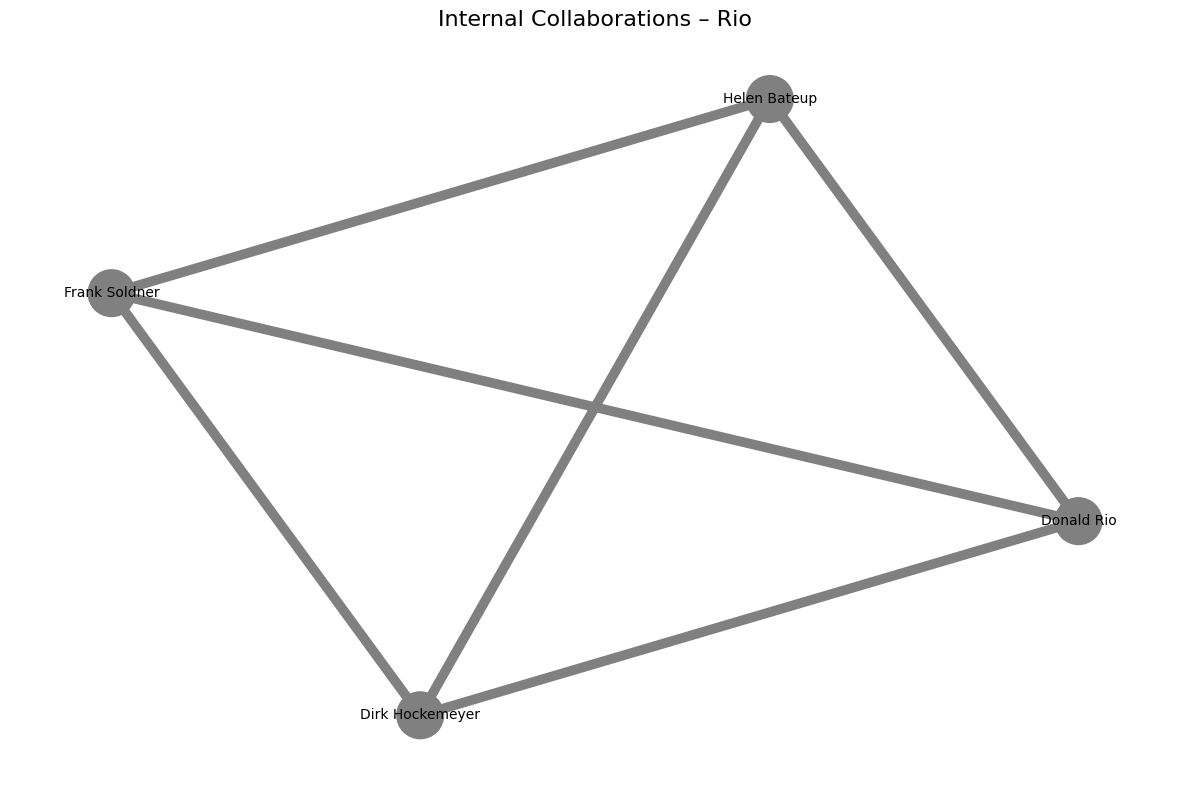

In [44]:
draw_team_internal_network("Rio", G, main_pi_df, color_palette, "grey", 1)

# Internal vs External Analysis

### Create df for internal and external scores - all works

In [45]:
from collections import defaultdict
from itertools import combinations

# Filter rows with publication IDs only
filtered_df = main_pi_df.dropna(subset=['OpenAlex_ID'])

# Group each publication by unique teams involved
pub_to_teams = filtered_df.groupby('OpenAlex_ID')['Team'].apply(lambda x: list(set(x)))

# Initialize dictionaries
edge_weights = defaultdict(int)
team_collab_counts = defaultdict(lambda: {"unique_teams": set(), "total_collabs": 0})

# Loop through publications to count collaborations between teams
for teams in pub_to_teams:
    unique_teams = list(set(teams))
    if len(unique_teams) > 1:
        for team1, team2 in combinations(sorted(unique_teams), 2):
            edge = tuple(sorted([team1, team2]))
            edge_weights[edge] += 1

            team_collab_counts[team1]["unique_teams"].add(team2)
            team_collab_counts[team1]["total_collabs"] += 1
            team_collab_counts[team2]["unique_teams"].add(team1)
            team_collab_counts[team2]["total_collabs"] += 1

# Now build the final DataFrame including ALL teams (even with 0 collaborations)
all_teams = sorted(main_pi_df['Team'].dropna().unique())

external_collab_data = []
for team in all_teams:
    data = team_collab_counts.get(team, {"unique_teams": set(), "total_collabs": 0})
    external_collab_data.append({
        'Team': team,
        'UniqueTeamsCollaboratedWith': len(data["unique_teams"]),
        'TotalExternalCollaborations': data["total_collabs"]
    })

external_collab_df = pd.DataFrame(external_collab_data)
external_collab_df.sort_values(by='Team', inplace=True)


In [46]:
external_collab_df = external_collab_df.merge(combined_teams[['Team','Supplement', 'Category',
       'Round']], on='Team', how='left' )

In [47]:
external_collab_df = external_collab_df.merge(main_pi_df[['Team','research_theme']], on='Team', how='left' )

In [48]:
for col in external_collab_df.columns:
    if external_collab_df[col].apply(lambda x: isinstance(x, list)).any():
        external_collab_df[col] = external_collab_df[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)

external_collab_df = external_collab_df.drop_duplicates()


In [49]:
external_collab_df = external_collab_df.drop_duplicates(subset=['Team'])

In [50]:
external_collab_df.columns

Index(['Team', 'UniqueTeamsCollaboratedWith', 'TotalExternalCollaborations',
       'Supplement', 'Category', 'Round', 'research_theme'],
      dtype='object')

In [51]:
import pandas as pd
from itertools import combinations
from collections import defaultdict
import ast

def extract_ids(cell):
    """Return a list of IDs from a cell (handles strings, lists, stringified lists)."""
    if pd.isna(cell):
        return []
    if isinstance(cell, (list, tuple, set)):
        return [str(x).strip() for x in cell if pd.notna(x)]
    s = str(cell).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, (list, tuple, set)):
                return [str(x).strip() for x in parsed if pd.notna(x)]
        except Exception:
            pass
    return [s] if s else []

# --- Step 1: All possible pairs per team (using PersonOpenAlex_ID to count everyone in team)
team_members = defaultdict(set)

for _, row in main_pi_df.iterrows():
    team = str(row['Team']).strip()
    for PersonOpenAlex_ID_id in extract_ids(row['PersonOpenAlex_ID']):
        if PersonOpenAlex_ID_id:
            team_members[team].add(PersonOpenAlex_ID_id)

team_possible_pairs = {
    team: set(combinations(sorted(members), 2)) if len(members) >= 2 else set()
    for team, members in team_members.items()
}

# --- Step 2: Actual observed pairs (using OpenAlex_ID + Team)
team_actual_pairs = defaultdict(set)

for (pub_id, team), group in main_pi_df.dropna(subset=['OpenAlex_ID']).groupby(['OpenAlex_ID', 'Team']):
    members_in_pub = set()
    for _, row in group.iterrows():
        members_in_pub.update(extract_ids(row['PersonOpenAlex_ID']))
    # form all pairs within that team for this publication
    if len(members_in_pub) >= 2:
        for combo in combinations(sorted(members_in_pub), 2):
            team_actual_pairs[team].add(combo)

# --- Step 3: Build DataFrame with score
internal_collab_data = []
for team, possible_pairs in team_possible_pairs.items():
    n_possible = len(possible_pairs)
    n_actual = len(team_actual_pairs.get(team, set()))
    score = n_actual / n_possible if n_possible > 0 else None
    internal_collab_data.append({
        "Team": team,
        "AllPossibleCombos": n_possible,
        "ActualCombosOccurred": n_actual,
        "InternalCollabScore": score
    })

internal_collab_df = pd.DataFrame(internal_collab_data).sort_values("Team")


In [52]:
external_collab_df = external_collab_df.merge(internal_collab_df[['Team','AllPossibleCombos', 'ActualCombosOccurred',
       'InternalCollabScore']], on='Team', how='left' )

### Scatterplot for internal vs external scores - all works

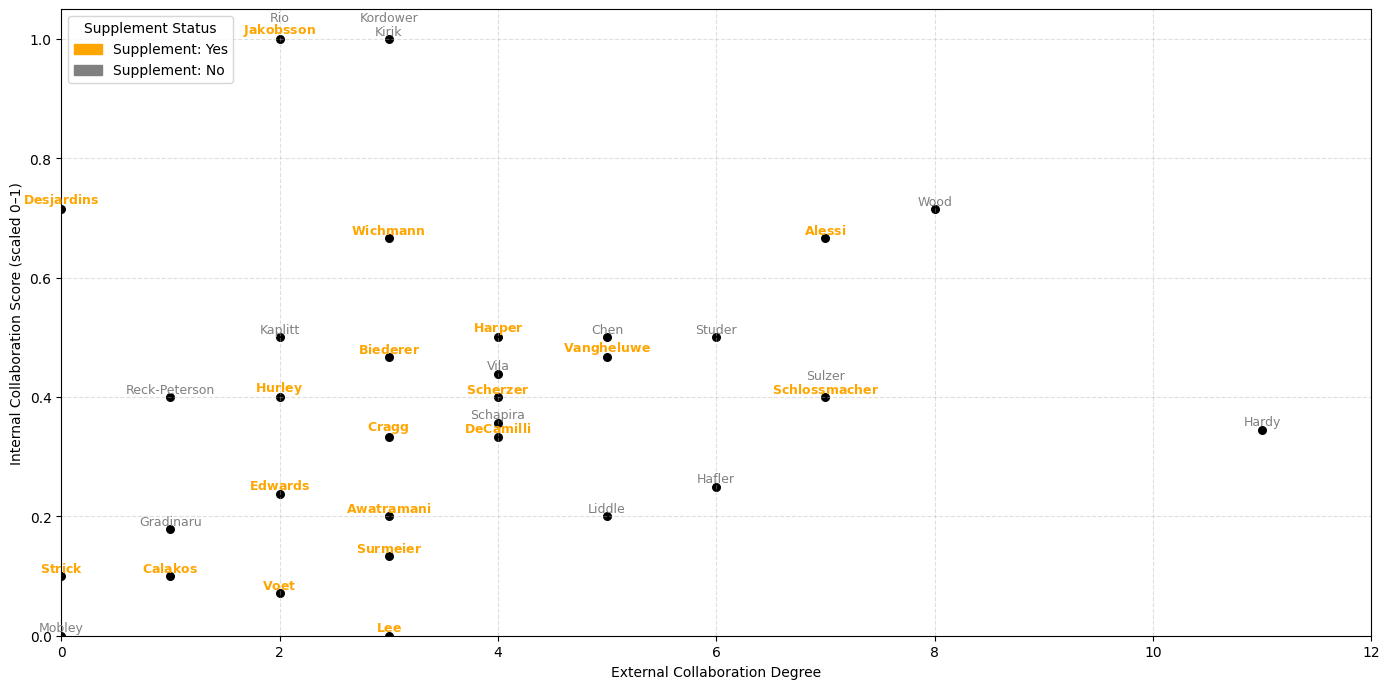

In [53]:
import matplotlib.pyplot as plt
import colorcet as cc
import pandas as pd

# Sort teams alphabetically for consistent color assignment
extra_and_intra_sorted = external_collab_df.sort_values('Team').reset_index(drop=True)
extra_and_intra_sorted = extra_and_intra_sorted[extra_and_intra_sorted['Team'] != 'MAC']

# Assign colors alphabetically
color_palette = cc.glasbey[:40] #change the coloring to use supplement_df

team_colors = {team: color_palette[i % len(color_palette)] for i, team in enumerate(extra_and_intra_sorted['Team'])}

# Scale values
extra_and_intra_sorted['InternalCollabScore_Scaled'] = extra_and_intra_sorted['InternalCollabScore']  # assumed 0-1
extra_and_intra_sorted['UniqueTeamsCollaboratedWith_Scaled'] = (
    extra_and_intra_sorted['UniqueTeamsCollaboratedWith'] / 15
).clip(0, 1)

# Create columns with final plot coords
extra_and_intra_sorted['x'] = extra_and_intra_sorted['UniqueTeamsCollaboratedWith_Scaled'] * 15
extra_and_intra_sorted['y'] = extra_and_intra_sorted['InternalCollabScore_Scaled']

# Group by coordinates to detect overlaps
grouped = extra_and_intra_sorted.groupby(['x', 'y'])



plt.figure(figsize=(14, 7))

for (x, y), group in extra_and_intra_sorted.groupby(['x', 'y']):
    teams = group['Team'].tolist()
    supplements = group['Supplement'].tolist()

    # Plot one dot for all overlapping teams
    plt.scatter(x, y, color="black", s=30)

    # Place each line of label separately with optional highlighting
    for i, (team, supp) in enumerate(zip(teams, supplements)):
        text_y = y + 0.002 + i * 0.023  # stack lines vertically

        if supp == 'Yes':
            plt.text(
            x, text_y, f"$\\bf{{{team}}}$", fontsize=9, ha='center', va='bottom',
            color='orange'
            )
        else:
            plt.text(
            x, text_y, team, fontsize=9, ha='center', va='bottom',
            color='grey'
            )

    # Add legend for supplement status
    import matplotlib.patches as mpatches
    legend_handles = [
        mpatches.Patch(color='orange', label='Supplement: Yes'),
        mpatches.Patch(color='grey', label='Supplement: No')
    ]
    plt.legend(handles=legend_handles, loc='upper left', title='Supplement Status')

plt.xlabel("External Collaboration Degree")
plt.ylabel("Internal Collaboration Score (scaled 0–1)")
#plt.title("Team Internal vs External Collaboration")
plt.ylim(0, 1.05)
plt.xlim(0, 12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('scatterplot_internal_vs_external_collab_by_supplement.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [54]:
{"PD Functional Genomics": "green", "Circuitry and Brain-Body Interactions": "blue", "Neuro-Immune Interactions":"purple"}

{'PD Functional Genomics': 'green',
 'Circuitry and Brain-Body Interactions': 'blue',
 'Neuro-Immune Interactions': 'purple'}

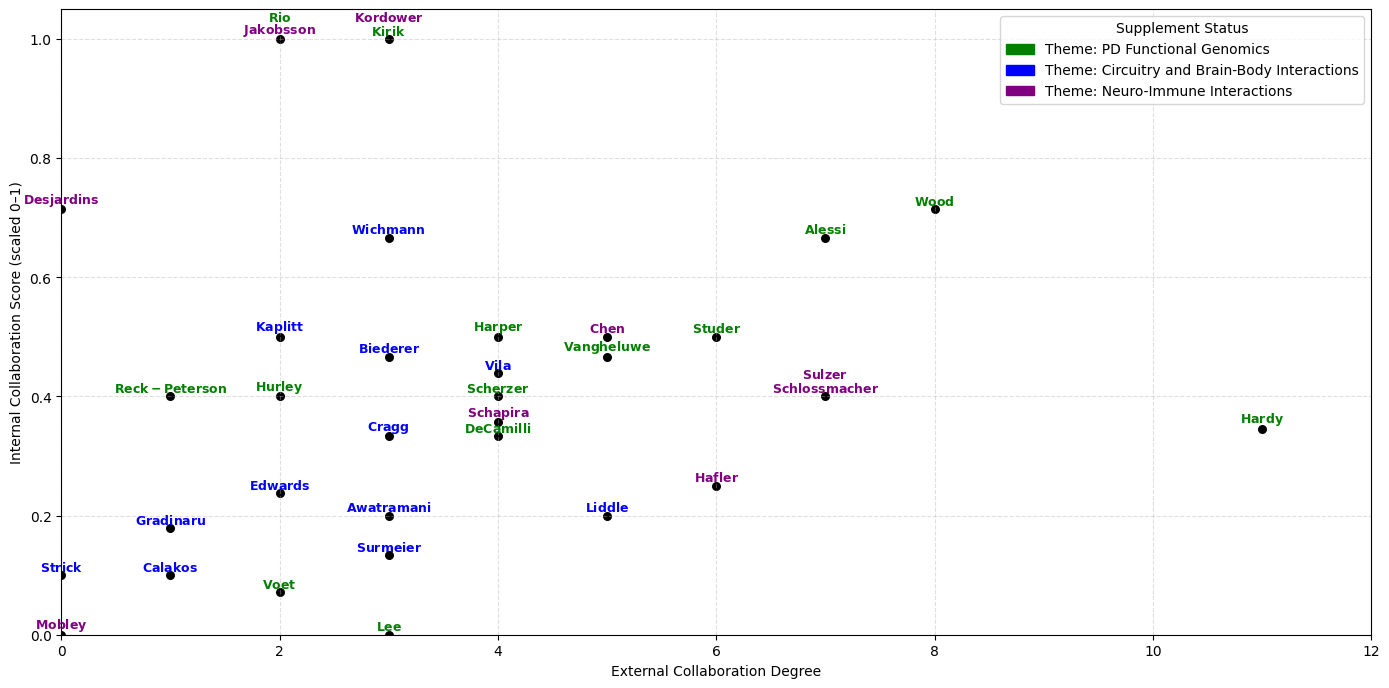

In [55]:
import matplotlib.pyplot as plt
import colorcet as cc
import pandas as pd

# Sort teams alphabetically for consistent color assignment
extra_and_intra_sorted = external_collab_df.sort_values('Team').reset_index(drop=True)
extra_and_intra_sorted = extra_and_intra_sorted[extra_and_intra_sorted['Team'] != 'MAC']

# Assign colors alphabetically
color_palette = cc.glasbey[:40] #change the coloring to use supplement_df

team_colors = {team: color_palette[i % len(color_palette)] for i, team in enumerate(extra_and_intra_sorted['Team'])}

# Scale values
extra_and_intra_sorted['InternalCollabScore_Scaled'] = extra_and_intra_sorted['InternalCollabScore']  # assumed 0-1
extra_and_intra_sorted['UniqueTeamsCollaboratedWith_Scaled'] = (
    extra_and_intra_sorted['UniqueTeamsCollaboratedWith'] / 15
).clip(0, 1)

# Create columns with final plot coords
extra_and_intra_sorted['x'] = extra_and_intra_sorted['UniqueTeamsCollaboratedWith_Scaled'] * 15
extra_and_intra_sorted['y'] = extra_and_intra_sorted['InternalCollabScore_Scaled']

# Group by coordinates to detect overlaps
grouped = extra_and_intra_sorted.groupby(['x', 'y'])



plt.figure(figsize=(14, 7))

for (x, y), group in extra_and_intra_sorted.groupby(['x', 'y']):
    teams = group['Team'].tolist()
    supplements = group['research_theme'].tolist()

    # Plot one dot for all overlapping teams
    plt.scatter(x, y, color="black", s=30)

    # Place each line of label separately with optional highlighting
    for i, (team, supp) in enumerate(zip(teams, supplements)):
        text_y = y + 0.002 + i * 0.023  # stack lines vertically

        if supp == 'PD Functional Genomics':
            plt.text(
            x, text_y, f"$\\bf{{{team}}}$", fontsize=9, ha='center', va='bottom',
            color='green'
            )
        elif supp == 'Circuitry and Brain-Body Interactions':
            plt.text(
            x, text_y, f"$\\bf{{{team}}}$", fontsize=9, ha='center', va='bottom',
            color='blue'
            )
        else:
            plt.text(
            x, text_y, f"$\\bf{{{team}}}$", fontsize=9, ha='center', va='bottom',
            color='purple'
            )

    # Add legend for supplement status
    import matplotlib.patches as mpatches
    legend_handles = [
        mpatches.Patch(color='green', label='Theme: PD Functional Genomics'),
        mpatches.Patch(color='blue', label='Theme: Circuitry and Brain-Body Interactions'),
        mpatches.Patch(color='purple', label='Theme: Neuro-Immune Interactions')
    ]
    plt.legend(handles=legend_handles, loc='upper right', title='Supplement Status')
#{"PD Functional Genomics": "green", "Circuitry and Brain-Body Interactions": "blue", "Neuro-Immune Interactions":"purple"}
plt.xlabel("External Collaboration Degree")
plt.ylabel("Internal Collaboration Score (scaled 0–1)")
#plt.title("Team Internal vs External Collaboration")
plt.ylim(0, 1.05)
plt.xlim(0, 12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('rt_scatterplot_internal_vs_external_collab_by_supplement.pdf', bbox_inches='tight', dpi=300)
plt.show()


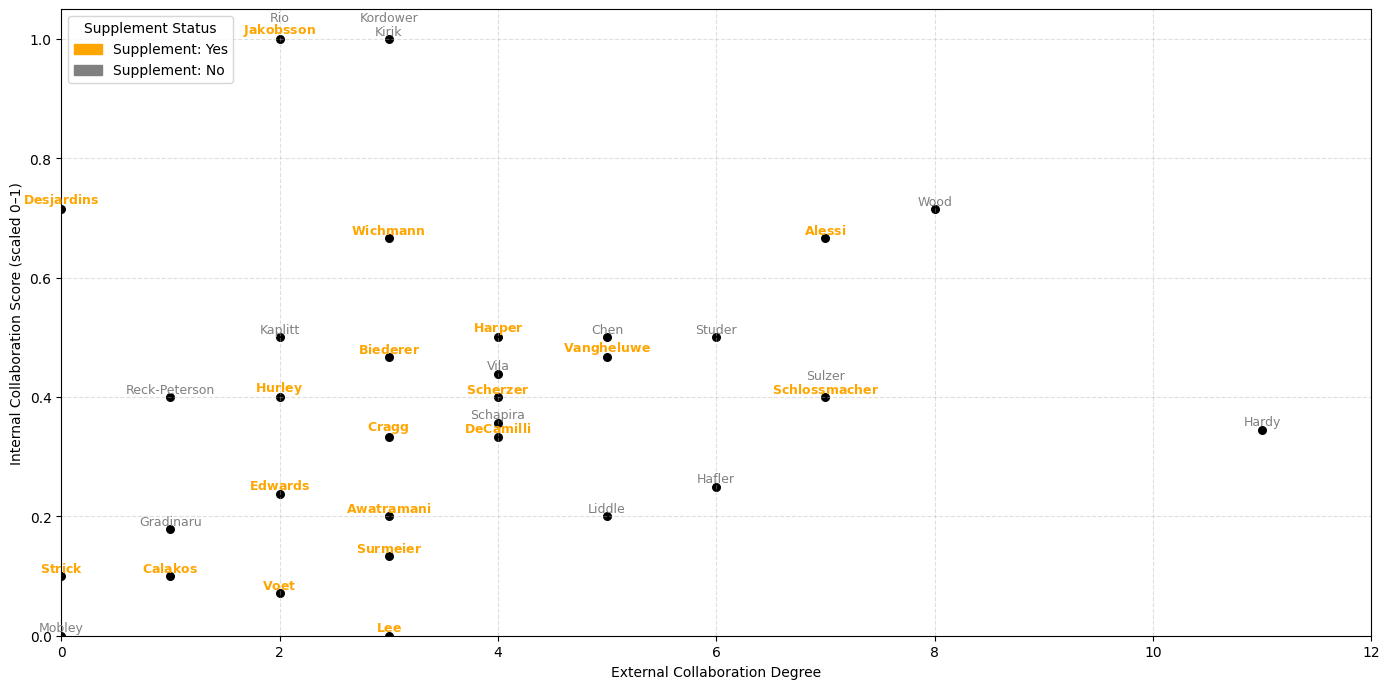

In [56]:
import matplotlib.pyplot as plt
import colorcet as cc
import pandas as pd

# Sort teams alphabetically for consistent color assignment
extra_and_intra_sorted = external_collab_df.sort_values('Team').reset_index(drop=True)
extra_and_intra_sorted = extra_and_intra_sorted[extra_and_intra_sorted['Team'] != 'MAC']

# Assign colors alphabetically
color_palette = cc.glasbey[:40] #change the coloring to use supplement_df

team_colors = {team: color_palette[i % len(color_palette)] for i, team in enumerate(extra_and_intra_sorted['Team'])}

# Scale values
extra_and_intra_sorted['InternalCollabScore_Scaled'] = extra_and_intra_sorted['InternalCollabScore']  # assumed 0-1
extra_and_intra_sorted['UniqueTeamsCollaboratedWith_Scaled'] = (
    extra_and_intra_sorted['UniqueTeamsCollaboratedWith'] / 15
).clip(0, 1)

# Create columns with final plot coords
extra_and_intra_sorted['x'] = extra_and_intra_sorted['UniqueTeamsCollaboratedWith_Scaled'] * 15
extra_and_intra_sorted['y'] = extra_and_intra_sorted['InternalCollabScore_Scaled']

# Group by coordinates to detect overlaps
grouped = extra_and_intra_sorted.groupby(['x', 'y'])



plt.figure(figsize=(14, 7))

for (x, y), group in extra_and_intra_sorted.groupby(['x', 'y']):
    teams = group['Team'].tolist()
    supplements = group['Supplement'].tolist()

    # Plot one dot for all overlapping teams
    plt.scatter(x, y, color="black", s=30)

    # Place each line of label separately with optional highlighting
    for i, (team, supp) in enumerate(zip(teams, supplements)):
        text_y = y + 0.002 + i * 0.023  # stack lines vertically

        if supp == 'Yes':
            plt.text(
            x, text_y, f"$\\bf{{{team}}}$", fontsize=9, ha='center', va='bottom',
            color='orange'
            )
        else:
            plt.text(
            x, text_y, team, fontsize=9, ha='center', va='bottom',
            color='grey'
            )

    # Add legend for supplement status
    import matplotlib.patches as mpatches
    legend_handles = [
        mpatches.Patch(color='orange', label='Supplement: Yes'),
        mpatches.Patch(color='grey', label='Supplement: No')
    ]
    plt.legend(handles=legend_handles, loc='upper left', title='Supplement Status')

plt.xlabel("External Collaboration Degree")
plt.ylabel("Internal Collaboration Score (scaled 0–1)")
#plt.title("Team Internal vs External Collaboration")
plt.ylim(0, 1.05)
plt.xlim(0, 12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('scatterplot_internal_vs_external_collab_by_supplement.pdf', bbox_inches='tight', dpi=300)
plt.show()


## Node Cartography

In [57]:
main_pi_df.columns

Index(['Title', 'team_x', 'doi_pre', 'doi_pub', 'date_added_preprint',
       'date_added_publication', 'source_preprint', 'source_publication',
       'original', 'notes', 'Preprint in SF tracker',
       'publication in SF tracker', 'apc_amount', 'apc_status', 'OpenAlex_ID',
       'PersonOpenAlex_ID', 'PersonName', 'PersonOrcid', 'Role', 'Team',
       'IsCorrespondingAuthor', 'Supplement', 'Category', 'Round',
       'research_theme', 'Team_List'],
      dtype='object')

Teams with std(k_within)==0 (team, size): []
       Team  k_total  k_within         z         P
0    Hurley        9       9.0  0.817440  0.000000
1    Hurley       11      10.0  1.057863  0.165289
2  Scherzer        2       2.0 -0.866703  0.000000
3      Voet        5       3.0  1.527525  0.560000
4      Voet        4       3.0  1.527525  0.375000


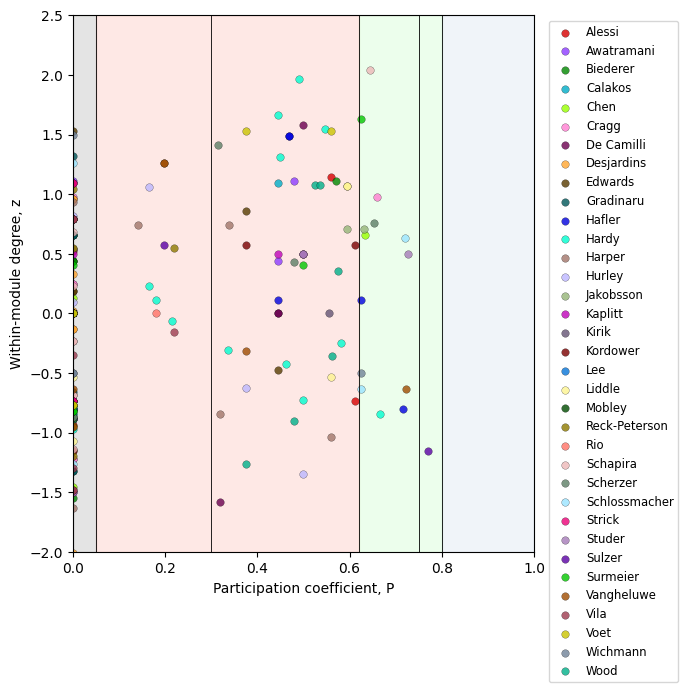

In [58]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict

# ---------- 1) Prepare person -> team mapping (deduplicate in case df has many rows) ----------
# df must have columns: 'OpenAlex_ID', 'PersonOpenAlex_ID', 'Team'
person_team = (
    df[['PersonOpenAlex_ID', 'Team']]
    .drop_duplicates(subset=['PersonOpenAlex_ID'])
    .set_index('PersonOpenAlex_ID')['Team']
    .to_dict()
)

# ---------- 2) Build weighted coauthorship graph ----------
G = nx.Graph()
# add nodes
for person, team in person_team.items():
    G.add_node(person, team=team)

# add weighted edges: for each publication, connect every pair of unique authors
for pub_id, group in df.groupby('OpenAlex_ID'):
    authors = group['PersonOpenAlex_ID'].unique().tolist()
    if len(authors) < 2:
        continue
    for u, v in combinations(authors, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)

# ---------- 3) Invert node->team to team->list_of_nodes ----------
team_nodes = defaultdict(list)
for n, attr in G.nodes(data=True):
    team_nodes[attr['team']].append(n)

# ---------- 4) Compute weighted within-module degree k_i(within team) for each node ----------
k_within = {}
for n in G.nodes():
    team_n = G.nodes[n]['team']
    # sum edge weights to neighbors in the same team
    k_in = sum(G[n][nbr].get('weight', 1) for nbr in G[n] if G.nodes[nbr]['team'] == team_n)
    k_within[n] = float(k_in)

# ---------- 5) Compute z-scores per team ----------
z_scores = {}
teams_with_std_zero = []
for team, nodes in team_nodes.items():
    # vals = np.array([k_within[n] for n in nodes], dtype=float)
    # mean_k = vals.mean() if len(vals) > 0 else 0.0
    # std_k = vals.std(ddof=0) if len(vals) > 0 else 0.0  # population std
    # if std_k == 0:
    #     # if everyone in the team has identical within-module degree (or team size==1),
    #     # z is undefined in principle; here we set to 0 (common pragmatic choice)
    #     for n in nodes:
    #         z_scores[n] = 0.0
    #     teams_with_std_zero.append((team, len(nodes)))
    #     # Replace the std calculation in your z-code block
    vals = np.array([k_within[n] for n in nodes], dtype=float)
    mean_k = vals.mean()
    std_k = vals.std(ddof=1) if len(vals) > 1 else 0.0
    if std_k == 0:
        z_scores[n] = np.nan   # or keep 0 if you prefer



    else:
        for n in nodes:
            z_scores[n] = (k_within[n] - mean_k) / std_k

# OPTIONAL debug: show teams with std==0 that produced zero z
print("Teams with std(k_within)==0 (team, size):", teams_with_std_zero[:10])
# If you see many teams here, that's expected if teams are singletons or everyone
# has same internal degree. Consider whether you want z = NaN instead.

# ---------- 6) Compute total degree k_i (weighted) and participation coefficient P ----------
P_scores = {}
deg_weight = dict(G.degree(weight='weight'))  # total weighted degree per node
all_teams = list(team_nodes.keys())

for n in G.nodes():
    ki = float(deg_weight.get(n, 0.0))
    if ki == 0.0:
        P_scores[n] = 0.0
        continue
    ssum = 0.0
    # for each team s, count weights from n to members of s
    for t in all_teams:
        kis = sum(G[n][nbr].get('weight', 1) for nbr in G[n] if G.nodes[nbr]['team'] == t)
        frac = kis / ki
        ssum += frac * frac
    P_scores[n] = 1.0 - ssum

# ---------- 7) Build results DataFrame ----------
results = pd.DataFrame({
    'Person': list(G.nodes()),
    'Team': [G.nodes[n]['team'] for n in G.nodes()],
    'k_total': [deg_weight.get(n, 0.0) for n in G.nodes()],
    'k_within': [k_within[n] for n in G.nodes()],
    'z': [z_scores.get(n, 0.0) for n in G.nodes()],
    'P': [P_scores.get(n, 0.0) for n in G.nodes()],
})

# quick check
print(results[['Team','k_total','k_within','z','P']].head())

# ---------- 8) Plot like Guimerà & Amaral with shaded role regions ----------
# region boundaries (standard choices)
z_cut = 2.5
P_r1 = 0.05
P_r2 = 0.62
P_r3 = 0.80
P_top_r5 = 0.30
P_top_r6 = 0.75

zmin, zmax = -2, 8
fig, ax = plt.subplots(figsize=(7,7))

# bottom band (zmin -> z_cut)
ax.add_patch(Rectangle((0.0, zmin), P_r1 - 0.0, z_cut - zmin, color='0.15', alpha=0.12))   # R1 (dark)
ax.add_patch(Rectangle((P_r1, zmin), P_r2 - P_r1, z_cut - zmin, color='salmon', alpha=0.18)) # R2
ax.add_patch(Rectangle((P_r2, zmin), P_r3 - P_r2, z_cut - zmin, color='palegreen', alpha=0.18)) # R3
ax.add_patch(Rectangle((P_r3, zmin), 1.0 - P_r3, z_cut - zmin, color='lightsteelblue', alpha=0.18)) # R4

# top band (z_cut -> zmax)
ax.add_patch(Rectangle((0.0, z_cut), P_top_r5 - 0.0, zmax - z_cut, color='khaki', alpha=0.18))       # R5
ax.add_patch(Rectangle((P_top_r5, z_cut), P_top_r6 - P_top_r5, zmax - z_cut, color='rosybrown', alpha=0.37)) # R6
ax.add_patch(Rectangle((P_top_r6, z_cut), 1.0 - P_top_r6, zmax - z_cut, color='lightgray', alpha=0.2))      # R7

# plot role boundary lines
ax.axvline(P_r1, color='k', lw=0.6)
ax.axvline(P_r2, color='k', lw=0.6)
ax.axvline(P_r3, color='k', lw=0.6)
ax.axvline(P_top_r5, color='k', lw=0.6)
ax.axvline(P_top_r6, color='k', lw=0.6)
ax.axhline(z_cut, color='k', lw=0.6)
import colorcet as cc
# color nodes by team (34 teams -> use repeated colormap)
unique_teams = sorted(team_nodes.keys())
ncolors = max(20, len(unique_teams))  # at least 20 in tab20
palette = cc.glasbey[:40]#plt.cm.tab20(np.linspace(0, 1, 20))
team_color_map = {t: palette[i % len(palette)] for i, t in enumerate(unique_teams)}

# scatter
for t, group in results.groupby('Team'):
    ax.scatter(group['P'], group['z'], s=30, alpha=0.8, label=t, color=team_color_map[t], edgecolor='k', linewidth=0.2)

ax.set_xlim(0, 1)
ax.set_ylim(zmin, 2.5)
ax.set_xlabel("Participation coefficient, P")
ax.set_ylabel("Within-module degree, z")
#ax.set_title("Node cartography: z vs P (colored by Team)")

# legend: many teams -> either omit or show outside (here we show a compact legend)
ax.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', fontsize='small', ncol=1)
plt.tight_layout()
plt.savefig('node_cartography_z_vs_P_by_team_cutoff.pdf', bbox_inches='tight', dpi=300)
plt.show()


# Collaboration Breakdown

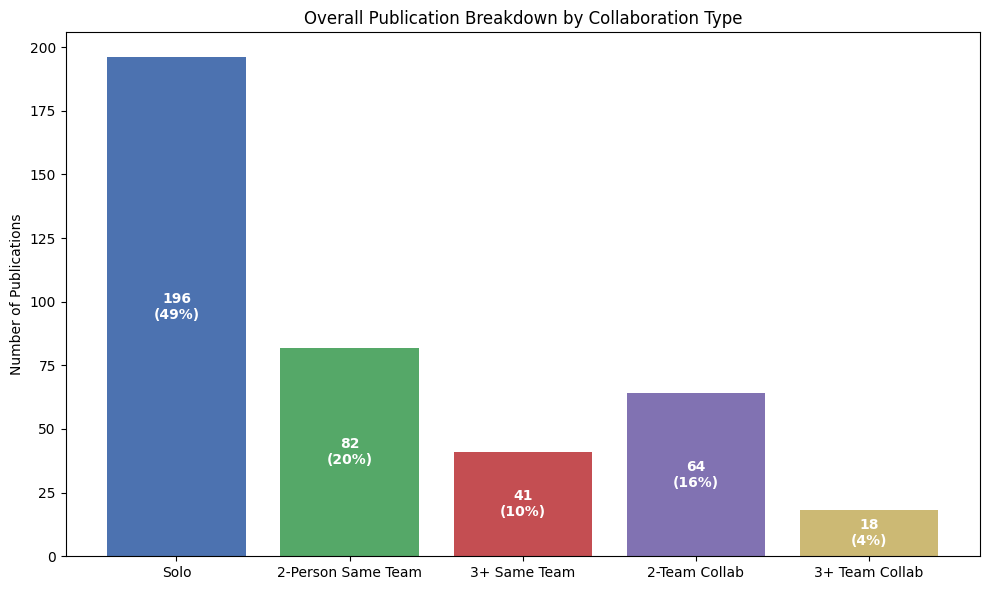

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Define categories
categories = [
    "Solo", 
    "2-Person Same Team", 
    "3+ Same Team", 
    "2-Team Collab", 
    "3+ Team Collab"
]

# Build mapping: person -> list of teams
person_to_teams = (
    main_pi_df.groupby('PersonOpenAlex_ID')['Team']
    .unique()
    .to_dict()
)

# Build publication participation dict
pub_to_authors = (
    main_pi_df[main_pi_df['OpenAlex_ID'].notna()]
    .groupby('OpenAlex_ID')['PersonOpenAlex_ID']
    .apply(set)
)

# Build publication to team mappings based on ALL teams each author belongs to
pub_to_all_teams = {}
for pub_id, authors in pub_to_authors.items():
    teams = set()
    for author in authors:
        teams.update(person_to_teams.get(author, []))
    pub_to_all_teams[pub_id] = teams

# Initialize counters
team_counts = defaultdict(lambda: defaultdict(int))
individual_counts = defaultdict(lambda: defaultdict(int))
overall_counts = defaultdict(int)

# Loop over publications
for pub_id, authors in pub_to_authors.items():
    all_teams_in_pub = pub_to_all_teams[pub_id]
    num_authors = len(authors)
    num_teams = len(all_teams_in_pub)

    if num_authors == 1:
        cat = "Solo"
    elif num_teams == 1 and num_authors == 2:
        cat = "2-Person Same Team"
    elif num_teams == 1 and num_authors >= 3:
        cat = "3+ Same Team"
    elif num_teams == 2:
        cat = "2-Team Collab"
    else:
        cat = "3+ Team Collab"

    overall_counts[cat] += 1
    overall_counts['total'] += 1

    for author in authors:
        author_teams = person_to_teams.get(author, [])
        for team in author_teams:
            team_counts[team][cat] += 1
            team_counts[team]['total'] += 1
        individual_counts[author][cat] += 1
        individual_counts[author]['total'] += 1

# Ensure all teams appear and that every team has all category keys (even with 0 publications)
all_teams = sorted(main_pi_df['Team'].dropna().unique())

# Initialize missing teams with zeroed categories
for team in all_teams:
    if team not in team_counts:
        team_counts[team] = defaultdict(int)
    for cat in categories + ['total']:
        if cat not in team_counts[team]:
            team_counts[team][cat] = 0

# Also ensure any team that appeared in team_counts but was missing some categories gets them
for team, counts in team_counts.items():
    for cat in categories + ['total']:
        if cat not in counts:
            counts[cat] = 0

# Convert team_counts to DataFrame
tc_df = pd.DataFrame(team_counts).T.fillna(0).astype(int)
tc_df = tc_df[categories + ['total']]
tc_df['collab_total'] = tc_df[['2-Person Same Team', '3+ Same Team', '2-Team Collab', '3+ Team Collab']].sum(axis=1)
tc_df = tc_df.sort_values(by='collab_total', ascending=False)

# OVERALL BARPLOT
fig, ax = plt.subplots(figsize=(10, 6))
overall_vals = [overall_counts[cat] for cat in categories]
total_pubs = overall_counts['total']

#bars = ax.bar(categories, overall_vals, color=colors[:len(categories)])
# python
# supply a list of colors (one per category)
color_list = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974'][:len(categories)]
bars = ax.bar(categories, overall_vals, color=color_list)
for bar, val in zip(bars, overall_vals):
    pct = val / total_pubs * 100 if total_pubs else 0
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, f"{val}\n({round(pct)}%)",
            ha='center', va='center', fontsize=10, color='white', fontweight='bold')

ax.set_title("Overall Publication Breakdown by Collaboration Type")
ax.set_ylabel("Number of Publications")
plt.tight_layout()
plt.savefig('overall_publication_breakdown_by_collaboration_type.png', bbox_inches='tight', dpi=300)
plt.show()
